## 4.2 Zero-Coupon bond Prcing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class FractionalVasicekModel:
    """
    Fractional Vasicek Model for Zero-Coupon Bond Pricing using Young Integration
    """
    
    def __init__(self, alpha, mu, sigma, r0):
        self.alpha = alpha  # mean reversion speed
        self.mu = mu        # long-term mean
        self.sigma = sigma  # volatility
        self.r0 = r0        # initial rate
    
    def generate_fbm_increments(self, M, N, T, H):
        """
        Generate M paths of fBm increments using Davies-Harte method
        M: number of paths
        N: number of time steps
        T: time horizon
        H: Hurst parameter
        """
        def autocovariance(k, H):
            return 0.5 * (abs(k - 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k + 1)**(2 * H))
        
        dt = T / N
        cov = np.zeros(2 * N)
        for k in range(2 * N):
            j = k if k <= N else 2 * N - k
            cov[k] = autocovariance(j, H)
        
        eigenvals = np.real(fft(cov))
        eigenvals = np.maximum(eigenvals, 1e-10)  # ensure positivity
        
        Z = np.random.normal(size=(M, 2 * N)) + 1j * np.random.normal(size=(M, 2 * N))
        W = np.sqrt(eigenvals / (2 * N)) * Z
        fGn = np.fft.ifft(W).real[:, :N]
        fBm_increments = fGn * np.sqrt(dt)
        
        return fBm_increments
    
    def generate_fbm_paths(self, M, N, T, H):
        """
        Generate fractional Brownian motion paths from increments
        """
        fbm_increments = self.generate_fbm_increments(M, N, T, H)
        fbm_paths = np.zeros((M, N + 1))
        fbm_paths[:, 1:] = np.cumsum(fbm_increments, axis=1)
        return fbm_paths
    
    def young_integral(self, integrand_paths, fbm_paths, dt, H):
        """
        Compute Young integral using Riemann-Stieltjes approximation
        For H > 1/2, we can use left-point rule which converges to Young integral
        
        integrand_paths: shape (M, N+1) - the function to integrate
        fbm_paths: shape (M, N+1) - fractional Brownian motion paths
        dt: time step
        H: Hurst parameter
        """
        M, N_plus_1 = integrand_paths.shape
        N = N_plus_1 - 1
        
        # ∫ f(s) dB_H(s) ≈ Σ f(t_i) [B_H(t_{i+1}) - B_H(t_i)]
        
        fbm_increments = np.diff(fbm_paths, axis=1)  # B_H(t_{i+1}) - B_H(t_i)
        integrand_left = integrand_paths[:, :-1]      # f(t_i)
        
        young_integral_result = np.sum(integrand_left * fbm_increments, axis=1)
        
        return young_integral_result
    
    
    def simulate_rate_paths_young(self, M, T, H, steps_per_year=252):
        """
        Advanced Young integration approach with better approximation
        Uses the fact that for linear SDE with fBm, we can get more accurate solutions
        """
        if H <= 0.5:
            raise ValueError("Young integration requires H > 0.5")
        
        N = int(T * steps_per_year)
        dt = T / N
        time_grid = np.linspace(0, T, N + 1)
        
        # Generate fractional Brownian motion paths
        fbm_paths = self.generate_fbm_paths(M, N, T, H)
        
        # For the Vasicek model with fBm, we can use the integrating factor method
        # combined with Young integration
        
        r_paths = np.zeros((M, N + 1))
        r_paths[:, 0] = self.r0
        
        for i in range(N):
            # Integrating factor approach
            exp_alpha_dt = np.exp(-self.alpha * dt)
            
            # Deterministic part
            mean_reversion = self.mu * (1 - exp_alpha_dt)
            
            # Stochastic part - Young integral of exp(α(s-t)) dB_H(s) from t to t+dt
            # For small dt, approximate as σ * [B_H(t+dt) - B_H(t)] * correction_factor
            correction_factor = (1 - exp_alpha_dt) / (self.alpha * dt) if self.alpha * dt > 1e-10 else 1.0
            stochastic_term = self.sigma * (fbm_paths[:, i + 1] - fbm_paths[:, i]) * correction_factor
            
            r_paths[:, i + 1] = r_paths[:, i] * exp_alpha_dt + mean_reversion + stochastic_term
        
        return r_paths, dt, fbm_paths
    
    def compute_bond_prices(self, r_paths, dt):
        """
        Compute zero-coupon bond prices
        """
        rate_integral = np.sum(r_paths[:, :-1] * dt, axis=1)
        bond_prices = np.exp(-rate_integral)
        return bond_prices

def comprehensive_analysis(hurst_values, maturities):
    """
    Comprehensive analysis of Hurst parameter effects on bond pricing
    """
    M = 1000  # number of paths
    
    # Model configurations
    configs = {
        'Baseline': {'alpha': 0.5, 'mu': 0.03, 'sigma': 0.2, 'r0': 0.03},
    }
    
    results = {}
    
    for config_name, params in configs.items():   
        model = FractionalVasicekModel(**params)
        config_results = {}
        
        for T in maturities:
            maturity_results = {}
            
            for H in hurst_values:
                
                # Simulate paths using Young integration
                r_paths, dt, fbm_paths = model.simulate_rate_paths_young(M, T, H)
                prices = model.compute_bond_prices(r_paths, dt)
                
                # Calculate statistics
                stats_dict = {
                    'mean': np.mean(prices),
                    'std': np.std(prices),
                    'skewness': stats.skew(prices, bias=False),
                    'kurtosis': stats.kurtosis(prices, bias=False),
                    'var_95': np.percentile(prices, 5),
                    'var_99': np.percentile(prices, 1),
                    'prices': prices,
                    'sample_paths': r_paths[:10],  # Store 10 sample paths
                    'sample_fbm': fbm_paths[:10]   # Store 10 sample fBm paths
                }
                
                maturity_results[H] = stats_dict
            
            config_results[T] = maturity_results
        
        results[config_name] = config_results
    
    return results

def create_comprehensive_plots(results, hurst_values, maturities):
    """
    Create comprehensive visualization of results
    """

    # 1. Sample Rate Paths
    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) 

    T_sample = 10

    for i, H in enumerate(hurst_values):
        row = i // 2
        col = i % 2
        
        # Rate paths
        ax1 = axes[row, col]
        rate_paths = results['Baseline'][T_sample][H]['sample_paths']
        time_grid = np.linspace(0, T_sample, rate_paths.shape[1])
        
        for path in rate_paths:
            ax1.plot(time_grid, path, alpha=0.7, linewidth=1)
        
        ax1.set_title(f'Rate Paths (H = {H:.2f})')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Interest Rate')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0.03, color='red', linestyle='--', alpha=0.8, label='Long-term mean')
        
        if i == 0:
            ax1.legend()
    
    # 2. Price Distribution Comparison
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, T in enumerate(maturities):
        ax = axes[i]
        for H in hurst_values:
            prices = results['Baseline'][T][H]['prices']
            ax.hist(prices, bins=50, alpha=0.6, label=f'H={H:.2f}', density=True)
        
        ax.set_title(f'Bond Price Distribution (T = {T} years)')
        ax.set_xlabel('Bond Price')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_mean_std_vs_hurst(results, hurst_values, maturities):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    measures = ['mean', 'std']
    measure_labels = ['Mean Price', 'Standard Deviation']

    for i, (measure, label) in enumerate(zip(measures, measure_labels)):
        ax = axes[i]

        for T in maturities:
            try:
                values = [results['Baseline'][T][H][measure] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'T={T}y', linewidth=2, markersize=6)
            except KeyError:
                print(f"Missing data for T={T}")
                continue

        ax.set_xlabel('Hurst Parameter (H)')
        ax.set_ylabel(label)
        ax.set_title(f'{label} vs Hurst Parameter')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_VaR_vs_hurst(results, hurst_values, maturities):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    measures = ['var_95', 'var_99']
    measure_labels = ['95% VaR', '99% VaR']

    for i, (measure, label) in enumerate(zip(measures, measure_labels)):
        ax = axes[i]

        for T in maturities:
            try:
                values = [results['Baseline'][T][H][measure] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'T={T}y', linewidth=2, markersize=6)
            except KeyError:
                print(f"Missing data for T={T}")
                continue

        ax.set_xlabel('Hurst Parameter (H)')
        ax.set_ylabel(label)
        ax.set_title(f'{label} vs Hurst Parameter')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def generate_summary_table(results):
    """
    Generate summary statistics table for Young integration results
    """
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    maturities = [1, 5, 10, 20, 30]
    
    print("\n" + "="*80)
    print("SUMMARY TABLE: BOND PRICING STATISTICS")
    print("="*80)
    
    # Create detailed summary
    for T in maturities:
        print(f"\nMaturity: {T} years")
        print("-" * 60)
        print(f"{'H':<6} {'Mean':<8} {'Std':<8} {'Skew':<8} {'Kurt':<8} {'VaR95':<8} {'VaR99':<8}")
        print("-" * 60)
        
        for H in hurst_values:
            stats_h = results['Baseline'][T][H]
            print(f"{H:<6.2f} {stats_h['mean']:<8.4f} {stats_h['std']:<8.4f} "
                  f"{stats_h['skewness']:<8.3f} {stats_h['kurtosis']:<8.3f} "
                  f"{stats_h['var_95']:<8.4f} {stats_h['var_99']:<8.4f}")

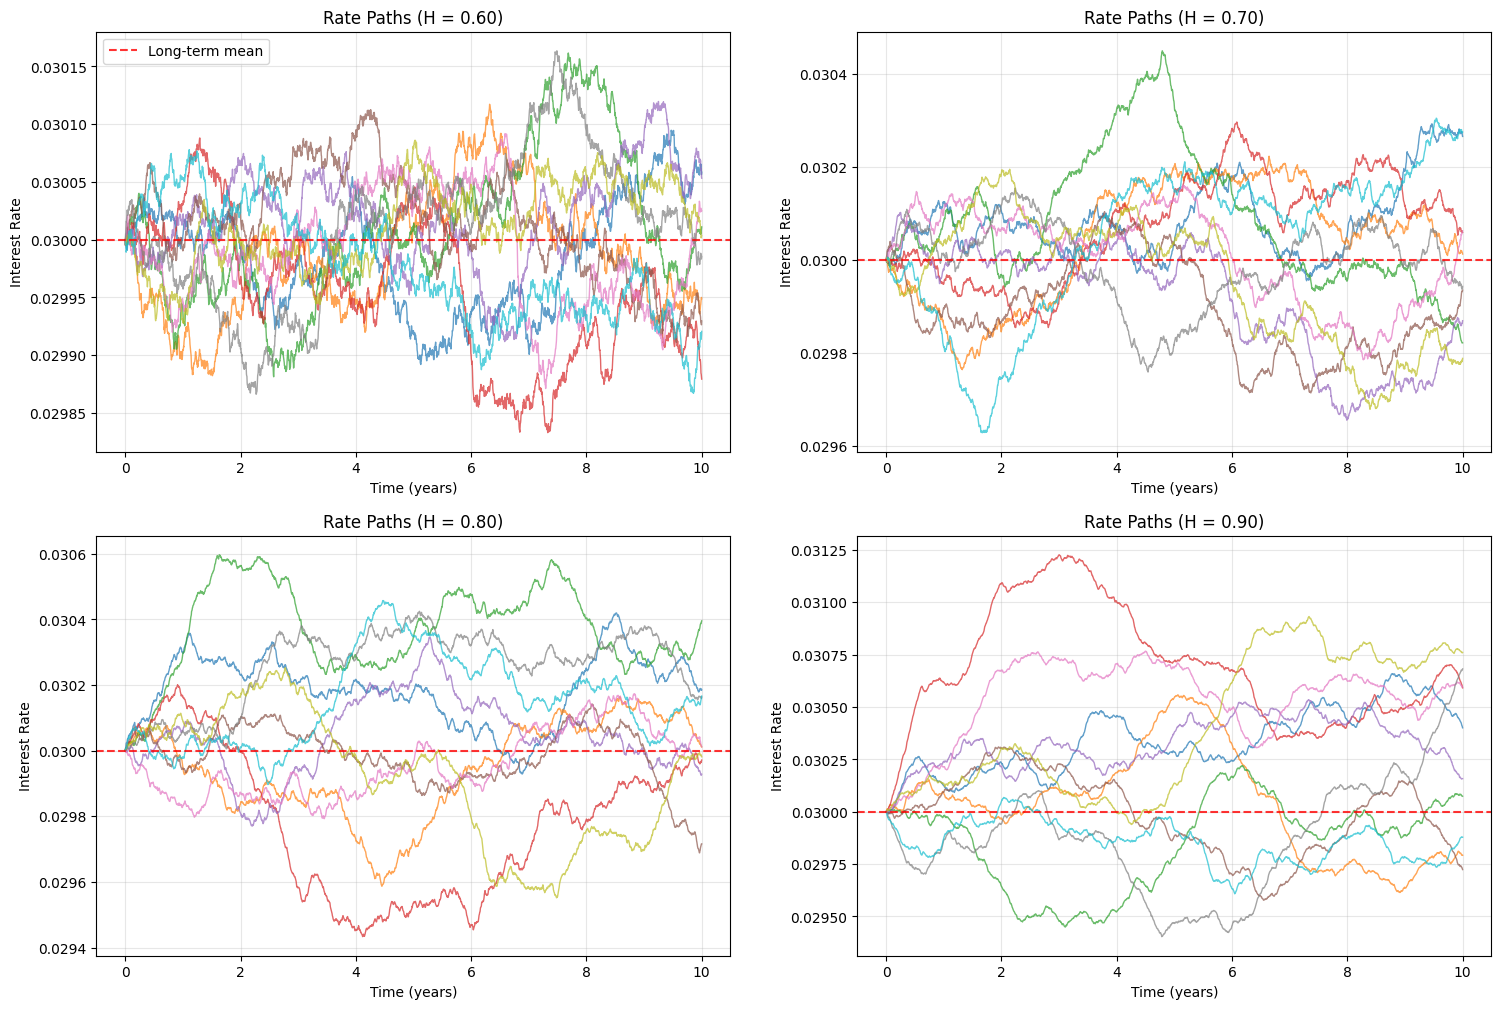

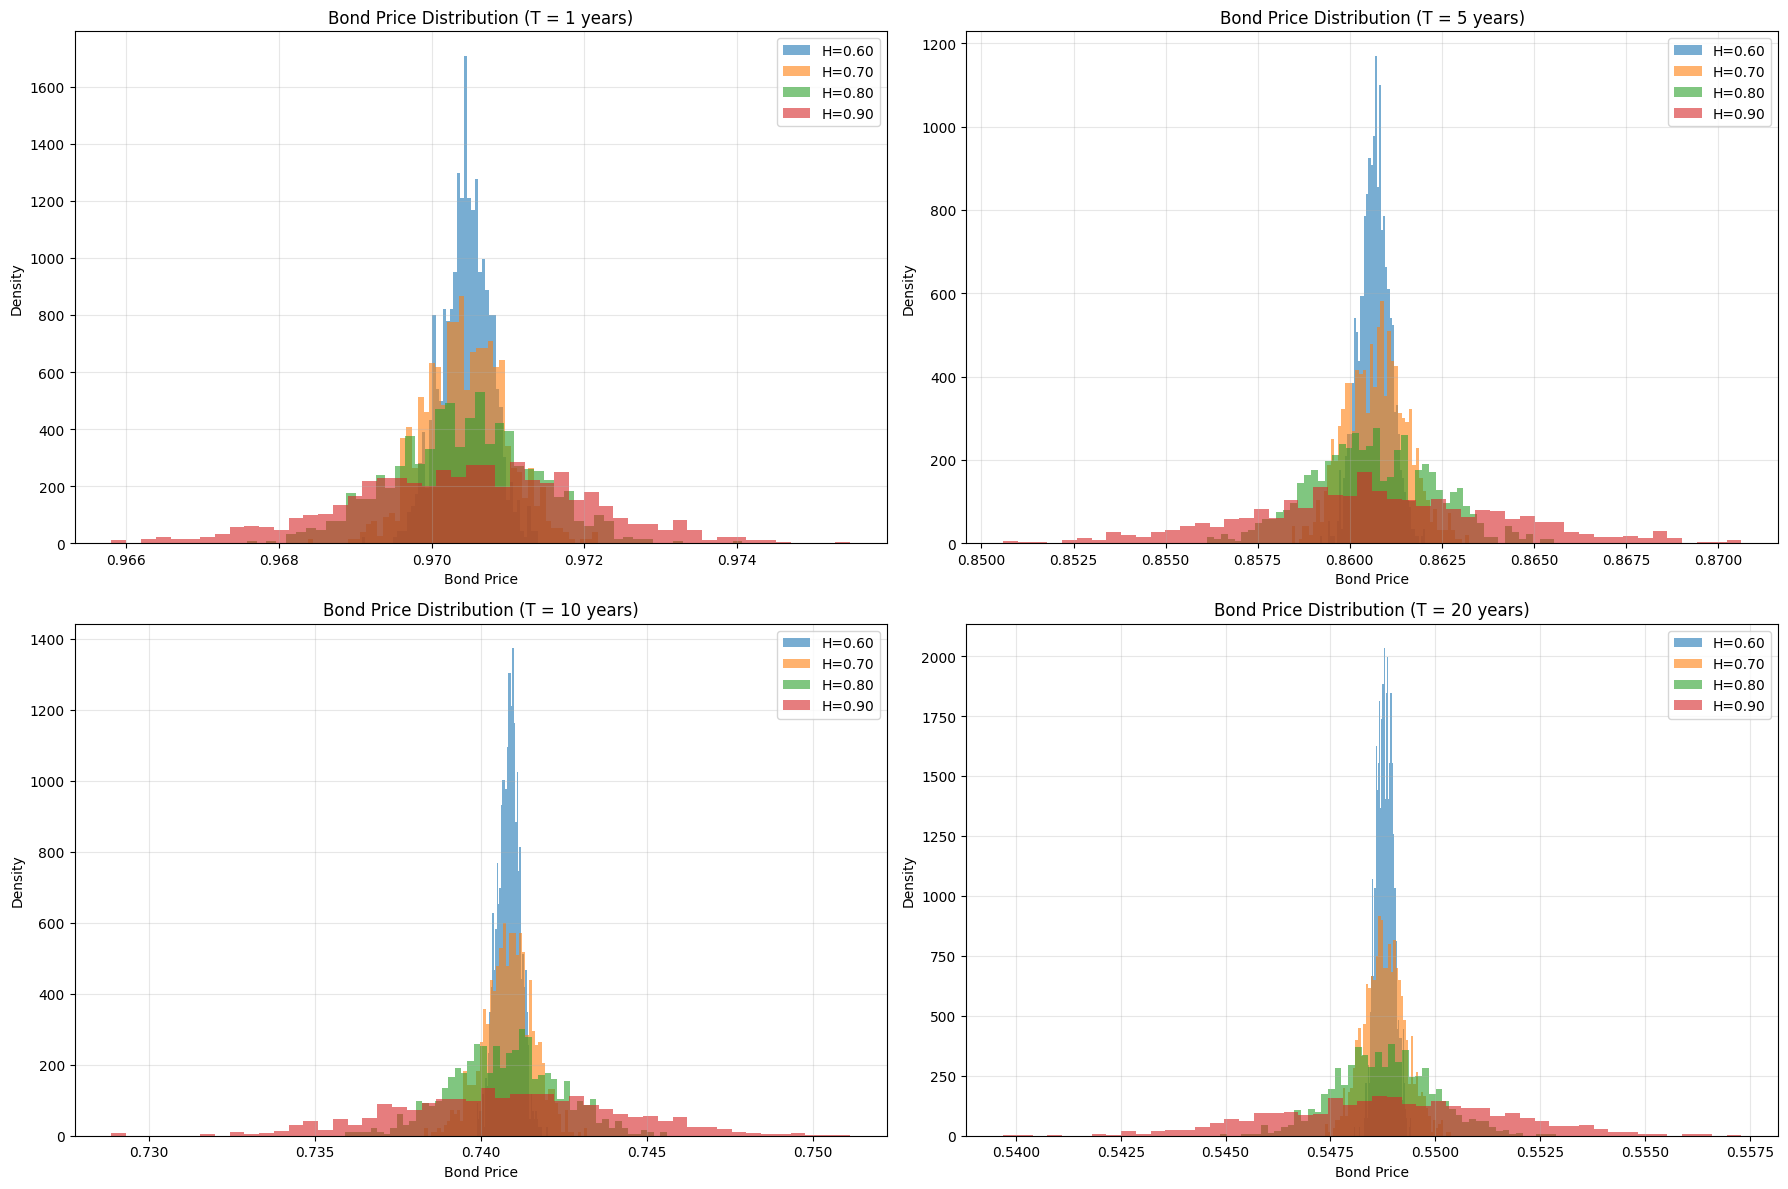

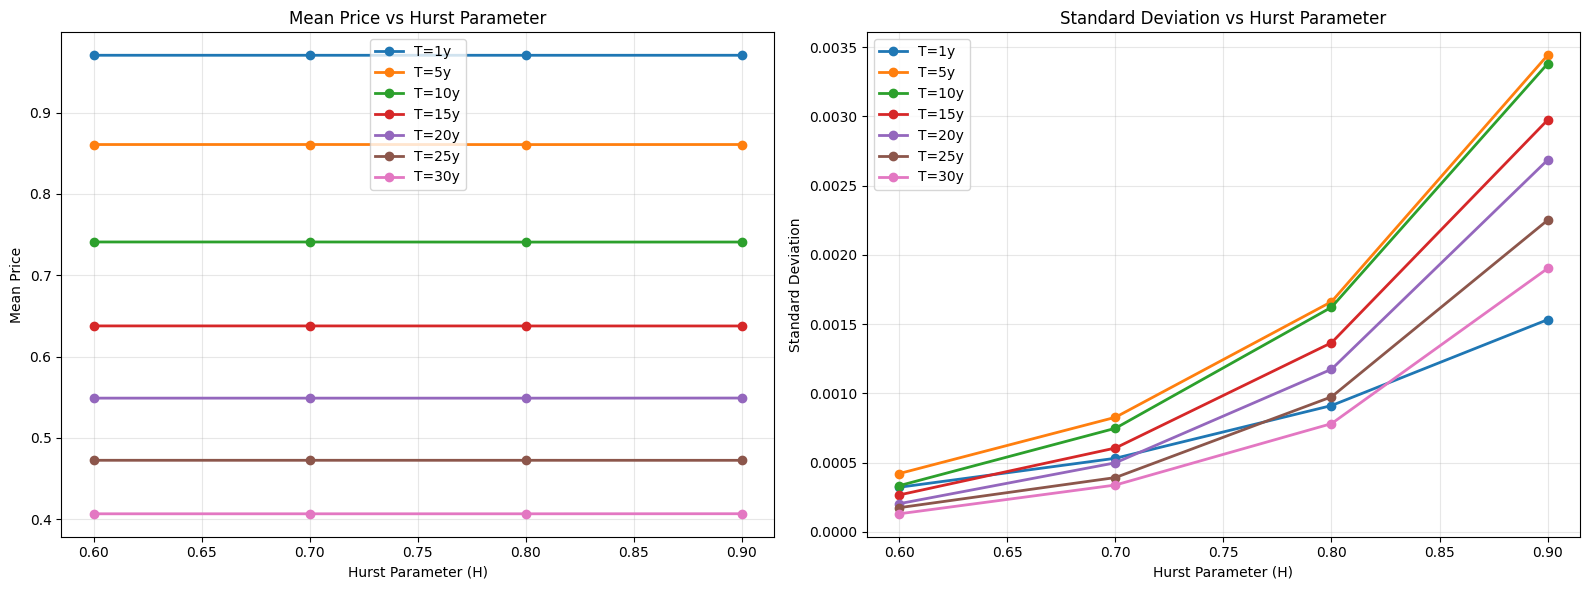

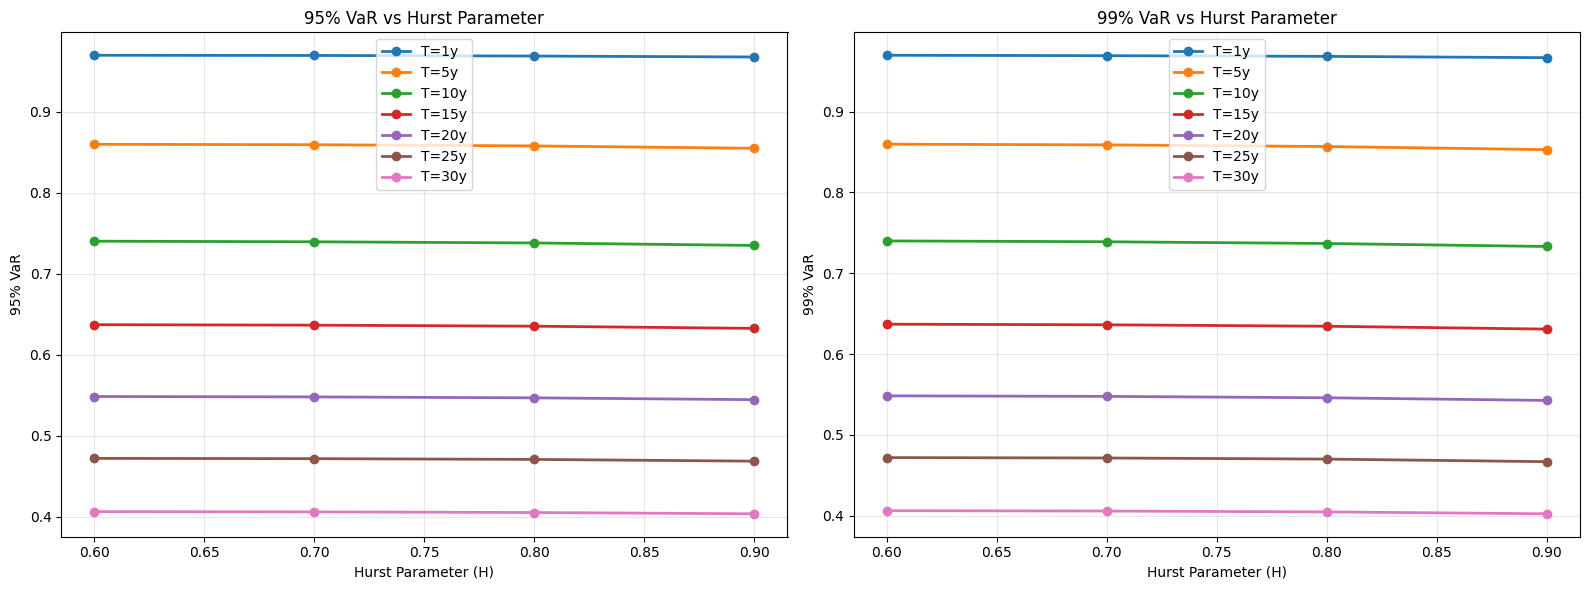


SUMMARY TABLE: BOND PRICING STATISTICS

Maturity: 1 years
------------------------------------------------------------
H      Mean     Std      Skew     Kurt     VaR95    VaR99   
------------------------------------------------------------
0.60   0.9705   0.0003   -0.128   0.177    0.9699   0.9697  
0.70   0.9704   0.0005   0.074    0.142    0.9696   0.9692  
0.80   0.9704   0.0009   0.010    -0.016   0.9689   0.9684  
0.90   0.9704   0.0015   -0.106   -0.042   0.9678   0.9667  

Maturity: 5 years
------------------------------------------------------------
H      Mean     Std      Skew     Kurt     VaR95    VaR99   
------------------------------------------------------------
0.60   0.8607   0.0004   -0.016   0.123    0.8600   0.8597  
0.70   0.8607   0.0008   0.064    -0.207   0.8594   0.8589  
0.80   0.8606   0.0017   0.093    -0.208   0.8579   0.8568  
0.90   0.8607   0.0034   0.047    -0.053   0.8550   0.8530  

Maturity: 10 years
------------------------------------------------

In [2]:
def main():
    """
    Main execution function
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Run comprehensive analysis
    results = comprehensive_analysis(hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    
    # Generate visualizations
    create_comprehensive_plots(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 20])
    plot_mean_std_vs_hurst(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    plot_VaR_vs_hurst(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    
    # Generate summary statistics
    generate_summary_table(results)
    
    print("\nAnalysis completed successfully!")
    
    return results

if __name__ == "__main__":
    results = main()

## 4.3 Forward Rate Agreement Pricing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class FractionalVasicekFRAModel:
    """
    Fractional Vasicek Model for Forward Rate Agreement (FRA) Pricing using Young Integration
    """
    
    def __init__(self, alpha, mu, sigma, r0):
        self.alpha = alpha  # mean reversion speed
        self.mu = mu        # long-term mean
        self.sigma = sigma  # volatility
        self.r0 = r0        # initial rate
    
    def generate_fbm_increments(self, M, N, T, H):
        """
        Generate M paths of fBm increments using Davies-Harte method
        M: number of paths
        N: number of time steps
        T: time horizon
        H: Hurst parameter
        """
        def autocovariance(k, H):
            return 0.5 * (abs(k - 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k + 1)**(2 * H))
        
        dt = T / N
        cov = np.zeros(2 * N)
        for k in range(2 * N):
            j = k if k <= N else 2 * N - k
            cov[k] = autocovariance(j, H)
        
        eigenvals = np.real(fft(cov))
        eigenvals = np.maximum(eigenvals, 1e-10)  # ensure positivity
        
        Z = np.random.normal(size=(M, 2 * N)) + 1j * np.random.normal(size=(M, 2 * N))
        W = np.sqrt(eigenvals / (2 * N)) * Z
        fGn = np.fft.ifft(W).real[:, :N]
        fBm_increments = fGn * np.sqrt(dt)
        
        return fBm_increments
    
    def generate_fbm_paths(self, M, N, T, H):
        """
        Generate fractional Brownian motion paths from increments
        """
        fbm_increments = self.generate_fbm_increments(M, N, T, H)
        fbm_paths = np.zeros((M, N + 1))
        fbm_paths[:, 1:] = np.cumsum(fbm_increments, axis=1)
        return fbm_paths
    
    def simulate_rate_paths_young(self, M, T, H, steps_per_year=252):
        """
        Advanced Young integration approach for rate simulation
        """
        if H <= 0.5:
            raise ValueError("Young integration requires H > 0.5")
        
        N = int(T * steps_per_year)
        dt = T / N
        time_grid = np.linspace(0, T, N + 1)
        
        # Generate fractional Brownian motion paths
        fbm_paths = self.generate_fbm_paths(M, N, T, H)
        
        # Simulate rate paths using Young integration
        r_paths = np.zeros((M, N + 1))
        r_paths[:, 0] = self.r0
        
        for i in range(N):
            # Integrating factor approach
            exp_alpha_dt = np.exp(-self.alpha * dt)
            
            # Deterministic part
            mean_reversion = self.mu * (1 - exp_alpha_dt)
            
            # Stochastic part - Young integral approximation
            correction_factor = (1 - exp_alpha_dt) / (self.alpha * dt) if self.alpha * dt > 1e-10 else 1.0
            stochastic_term = self.sigma * (fbm_paths[:, i + 1] - fbm_paths[:, i]) * correction_factor
            
            r_paths[:, i + 1] = r_paths[:, i] * exp_alpha_dt + mean_reversion + stochastic_term
        
        return r_paths, dt, fbm_paths, time_grid
    
    def compute_discount_factors(self, r_paths, dt, t, T_settlement):
        """
        Compute discount factors P(t, T_settlement) for each path
        """
        # Find the index corresponding to time t
        t_steps = int(t / dt)
        T_settlement_steps = int(T_settlement / dt)
        
        # Integrate rates from t to T_settlement
        rate_integral = np.sum(r_paths[:, t_steps:T_settlement_steps] * dt, axis=1)
        discount_factors = np.exp(-rate_integral)
        
        return discount_factors
    
    def compute_forward_rates(self, r_paths, dt, T_fixing, T_settlement):
        """
        Compute forward rates L_i = (1/tau_i) * (P(T_i, T_i)/P(T_i, T_{i+1}) - 1)
        """
        # Compute discount factors at fixing date
        P_Ti_Ti = np.ones(r_paths.shape[0])  # P(T_i, T_i) = 1
        P_Ti_Ti_plus_1 = self.compute_discount_factors(r_paths, dt, T_fixing, T_settlement)
        
        # Accrual factor (time between fixing and settlement)
        tau_i = T_settlement - T_fixing
        
        # Forward rate calculation
        forward_rates = (1 / tau_i) * (P_Ti_Ti / P_Ti_Ti_plus_1 - 1)
        
        return forward_rates
    
    def compute_fra_values(self, r_paths, dt, t, K, N_notional, T_fixing, T_settlement):
        """
        Compute FRA values using Monte Carlo simulation
        V^FRA(t; K, T_i) = P(t, T_{i+1}) * N * tau_i * E^{Q^{T_{i+1}}}[(L_i - K) | F_t]
        """
        # Discount factor from t to settlement
        P_t_T_settlement = self.compute_discount_factors(r_paths, dt, t, T_settlement)
        
        # Forward rates at fixing date
        forward_rates = self.compute_forward_rates(r_paths, dt, T_fixing, T_settlement)
        
        # Accrual factor
        tau_i = T_settlement - T_fixing
        
        # FRA payoff: N * tau_i * (L_i - K)
        fra_payoffs = N_notional * tau_i * (forward_rates - K)
        
        # Discounted FRA values
        fra_values = P_t_T_settlement * fra_payoffs
        
        return fra_values, forward_rates

def comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates):
    """
    Comprehensive analysis of Hurst parameter effects on FRA pricing
    """
    M = 1000  # number of paths
    
    # Model parameters (baseline configuration)
    params = {'alpha': 0.5, 'mu': 0.03, 'sigma': 0.2, 'r0': 0.03}
    model = FractionalVasicekFRAModel(**params)
    
    # FRA contract parameters
    N_notional = 1000000  # $1M notional
    valuation_time = 0    # Current time
    
    results = {}
    
    for T_fixing, T_settlement in fra_maturities:
        maturity_key = f"{T_fixing}x{T_settlement}"
        maturity_results = {}
        
        for K in contract_rates:
            contract_results = {}
            
            for H in hurst_values:
                # Simulate paths
                max_T = max(T_settlement, 5)  # Ensure sufficient simulation horizon
                r_paths, dt, fbm_paths, time_grid = model.simulate_rate_paths_young(M, max_T, H)
                
                # Compute FRA values
                fra_values, forward_rates = model.compute_fra_values(
                    r_paths, dt, valuation_time, K, N_notional, T_fixing, T_settlement
                )
                
                # Calculate statistics
                stats_dict = {
                    'mean_fra_value': np.mean(fra_values),
                    'std_fra_value': np.std(fra_values),
                    'skewness_fra': stats.skew(fra_values, bias=False),
                    'kurtosis_fra': stats.kurtosis(fra_values, bias=False),
                    'var_95_fra': np.percentile(fra_values, 5),
                    'var_99_fra': np.percentile(fra_values, 1),
                    'mean_forward_rate': np.mean(forward_rates),
                    'std_forward_rate': np.std(forward_rates),
                    'fra_values': fra_values,
                    'forward_rates': forward_rates,
                    'sample_rate_paths': r_paths[:10],  # Store 10 sample paths
                    'sample_fbm': fbm_paths[:10]       # Store 10 sample fBm paths
                }
                
                contract_results[H] = stats_dict
            
            maturity_results[K] = contract_results
        
        results[maturity_key] = maturity_results
    
    return results


#### Sample Forward Rate Paths for different Hurst parameters

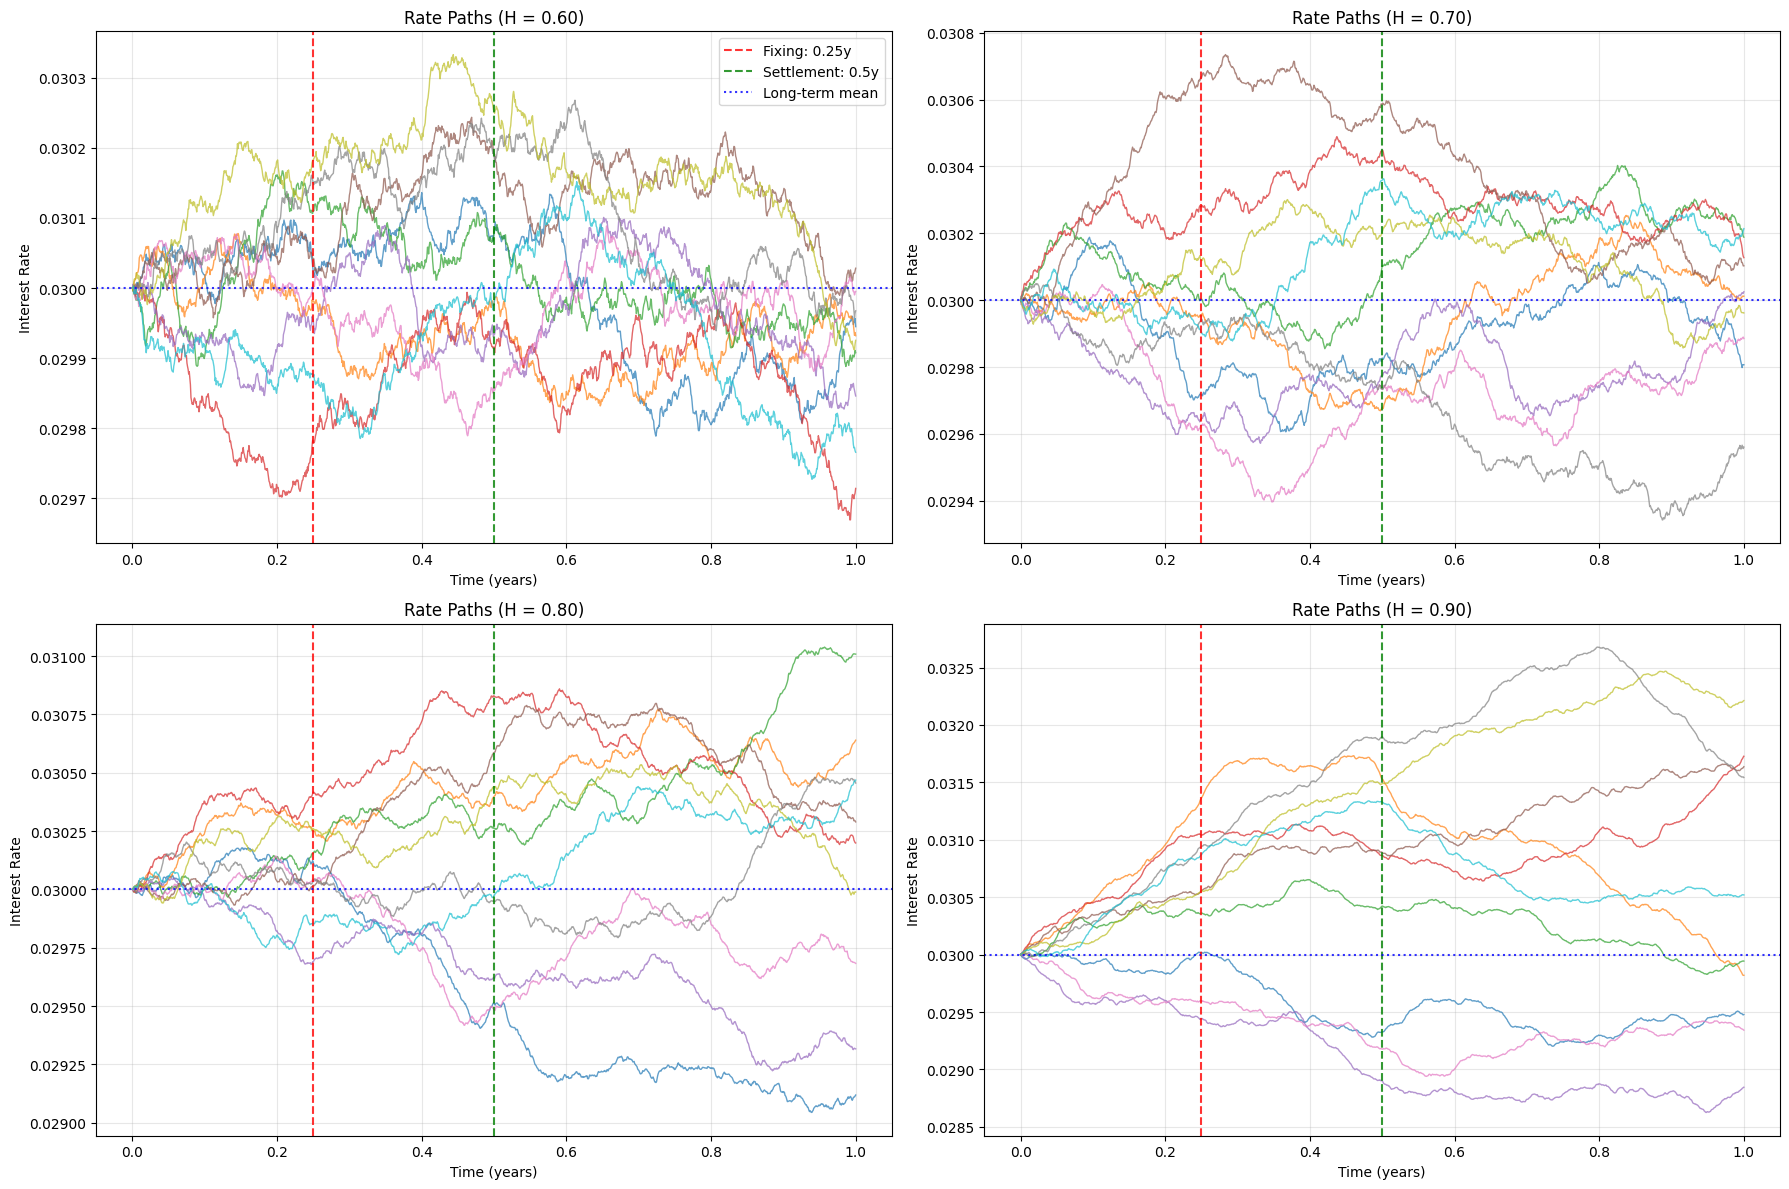

In [3]:
def forward_rate_paths(results, hurst_values, fra_maturities, contract_rates):
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    maturity_sample = f"{fra_maturities[0][0]}x{fra_maturities[0][1]}"
    K_sample = contract_rates[1] 
    
    for i, H in enumerate(hurst_values):
        row = i // 2
        col = i % 2
        
        ax = axes[row, col]
        rate_paths = results[maturity_sample][K_sample][H]['sample_rate_paths']
        max_T = max(fra_maturities[0][1], 1)
        time_grid = np.linspace(0, max_T, rate_paths.shape[1])
        
        for path in rate_paths:
            ax.plot(time_grid, path, alpha=0.7, linewidth=1)
        
        # Mark fixing and settlement dates
        ax.axvline(x=fra_maturities[0][0], color='red', linestyle='--', alpha=0.8, label=f'Fixing: {fra_maturities[0][0]}y')
        ax.axvline(x=fra_maturities[0][1], color='green', linestyle='--', alpha=0.8, label=f'Settlement: {fra_maturities[0][1]}y')
        
        ax.set_title(f'Rate Paths (H = {H:.2f})')
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Interest Rate')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0.03, color='blue', linestyle=':', alpha=0.8, label='Long-term mean')
        
        if i == 0:
            ax.legend()
    
    plt.tight_layout()
    plt.show()


def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    forward_rate_paths(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()

#### Forward Rate Distribution

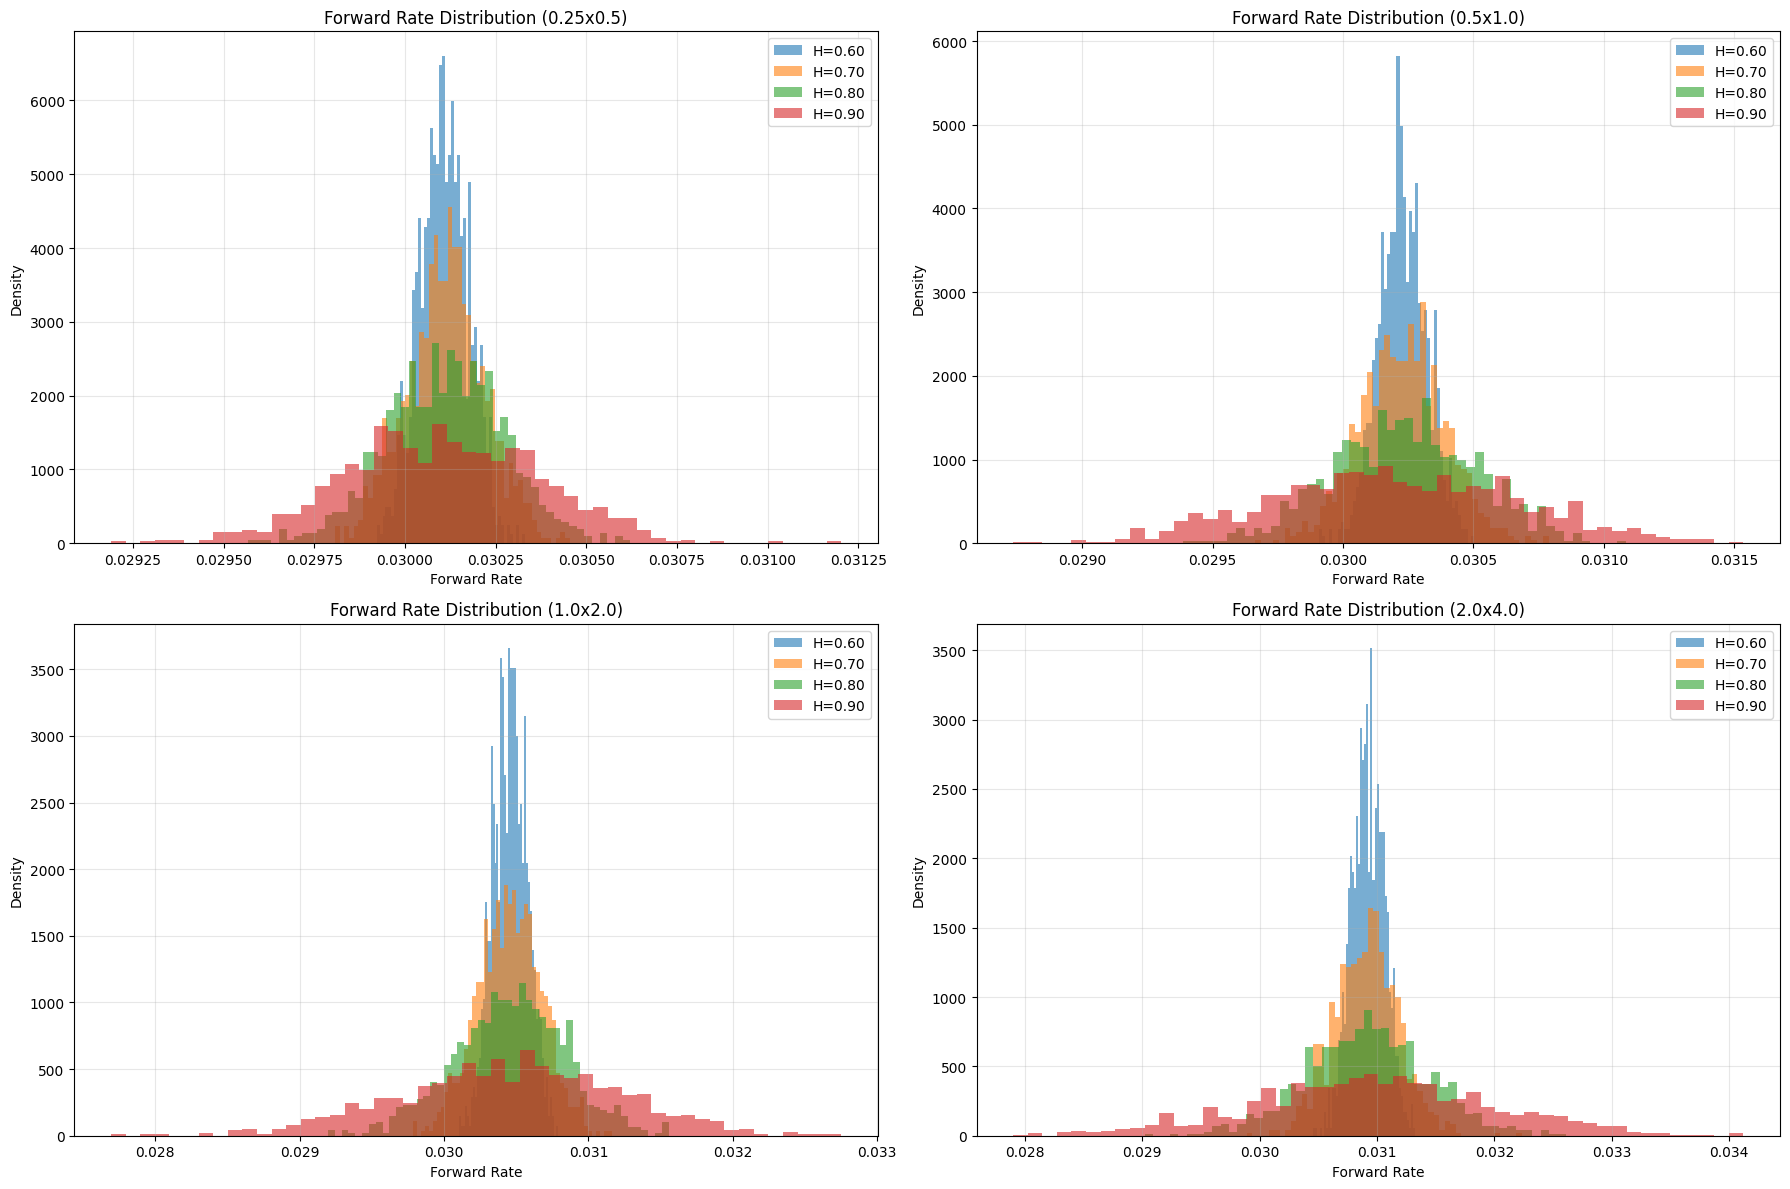

In [4]:
def forward_rate_distribution(results, hurst_values, fra_maturities, contract_rates):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
    for i, (T_fixing, T_settlement) in enumerate(fra_maturities):
        if i >= 4:
            break
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        maturity_key = f"{T_fixing}x{T_settlement}"
        K_sample = contract_rates[1] # Use middle contract rate
        
        for H in hurst_values:
            forward_rates = results[maturity_key][K_sample][H]['forward_rates']
            ax.hist(forward_rates, bins=50, alpha=0.6, label=f'H={H:.2f}', density=True)
        
        ax.set_title(f'Forward Rate Distribution ({T_fixing}x{T_settlement})')
        ax.set_xlabel('Forward Rate')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    forward_rate_distribution(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()

#### Statistical analysis for forward rate: mean and standard deviation

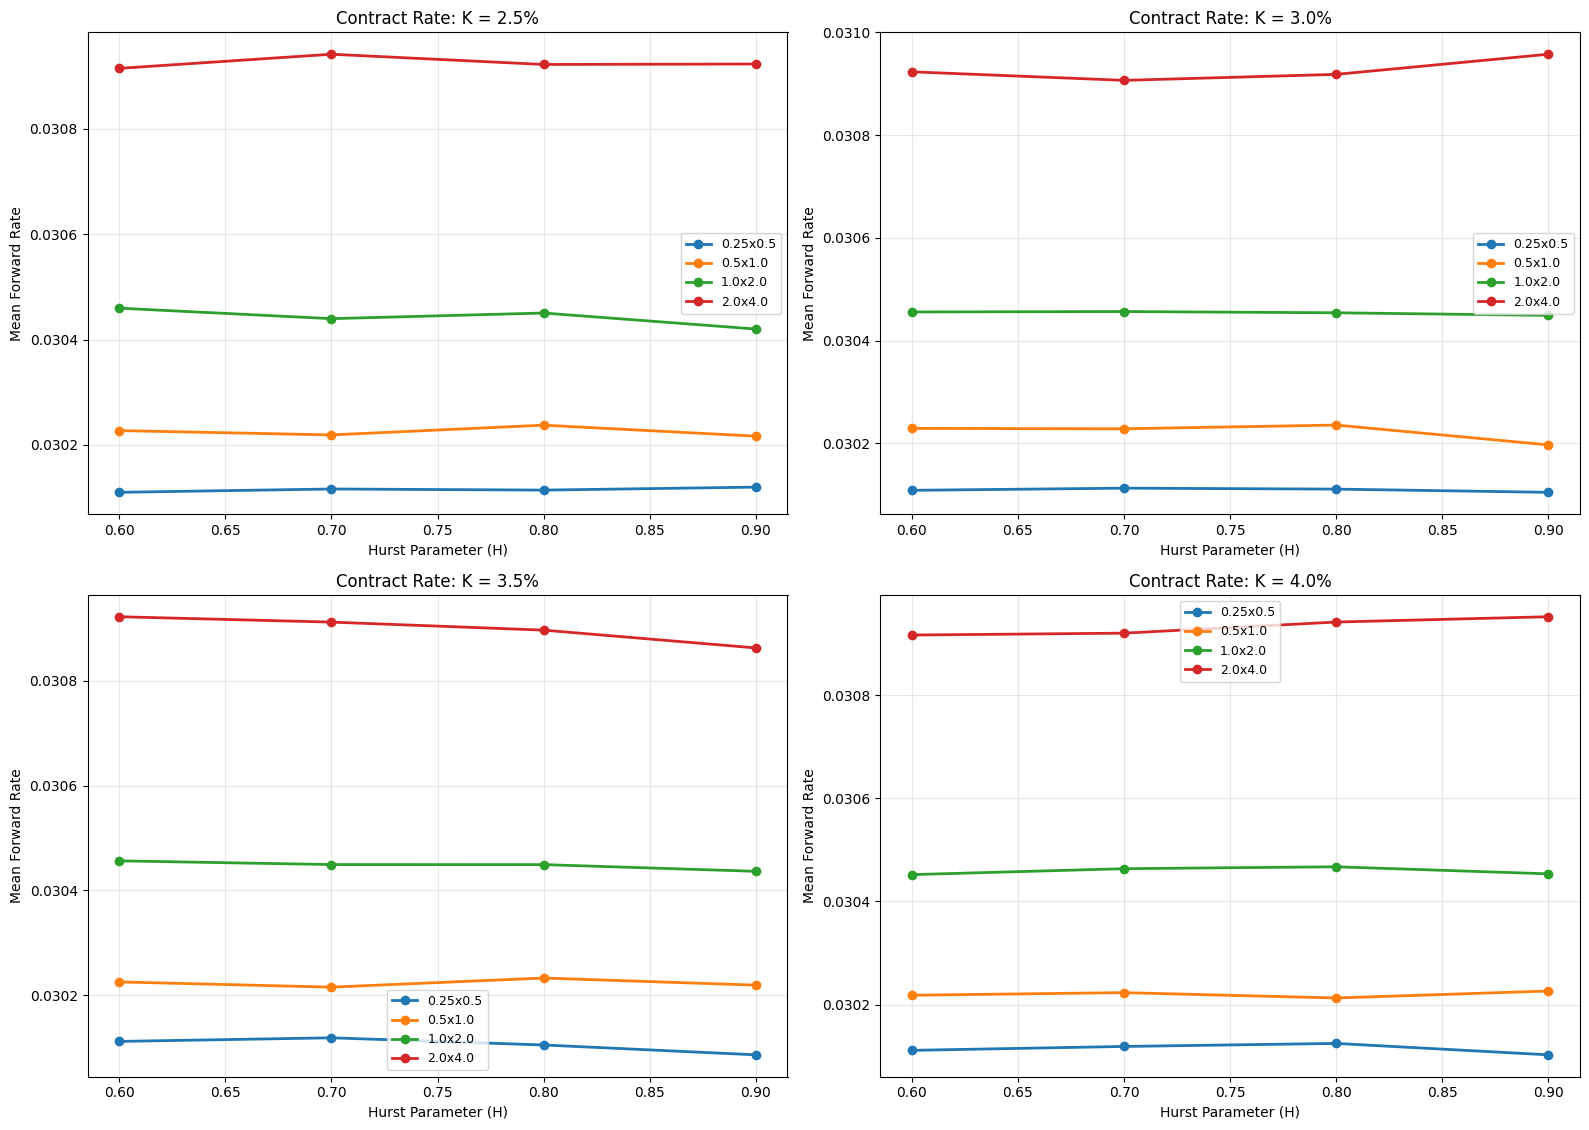

In [5]:
def mean_rate(results, hurst_values, fra_maturities, contract_rates):
    
    metric_sets = [
        ("mean_forward_rate", "Mean Forward Rate")
    ]

    for metric, label in metric_sets:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        # fig.suptitle(f'{label} vs Hurst Parameter (by Contract Rate)', fontsize=16)

        for idx, K in enumerate(contract_rates):
            row, col = divmod(idx, 2)
            ax = axes[row][col]

            for T_fixing, T_settlement in fra_maturities:
                maturity_key = f"{T_fixing}x{T_settlement}"
                values = [results[maturity_key][K][H][metric] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'{T_fixing}x{T_settlement}', linewidth=2)

            ax.set_title(f'Contract Rate: K = {K:.1%}')
            ax.set_xlabel('Hurst Parameter (H)')
            ax.set_ylabel(label)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    mean_rate(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()

Run Mean forward rate experiment with fixed Hurst parameter and varying K or term structures

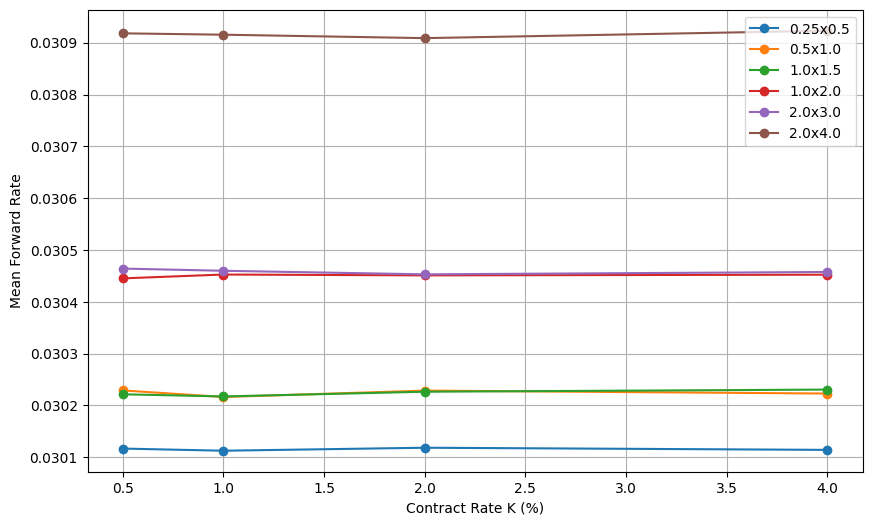

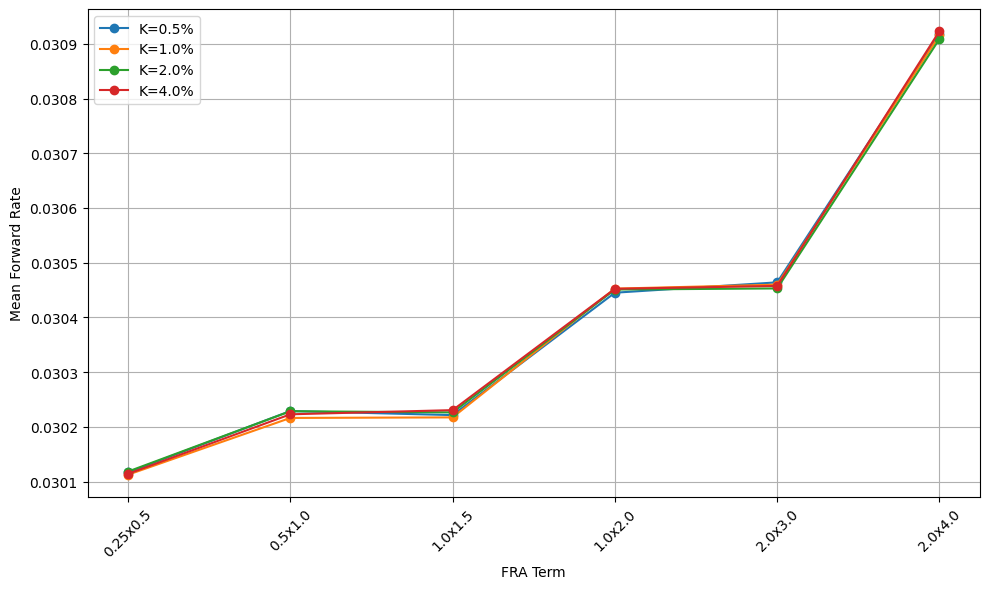

In [13]:
# === 1. Fixed H, Varying K and Term Structure ===
def run_fra_experiment_fixed_H(H_fixed, fra_maturities, contract_rates):
    
    # Initialize
    M = 1000
    params = {'alpha': 0.5, 'mu': 0.03, 'sigma': 0.2, 'r0': 0.03}
    model = FractionalVasicekFRAModel(**params)
    valuation_time = 0

    # Store mean forward rates by (K, maturity)
    mean_fwd_by_K = {K: [] for K in contract_rates}
    mean_fwd_by_maturity = {}

    for T_fixing, T_settlement in fra_maturities:
        maturity_key = f"{T_fixing}x{T_settlement}"
        mean_fwd_by_maturity[maturity_key] = []
        max_T = max(T_settlement, 5)
        for K in contract_rates:
            r_paths, dt, _, _ = model.simulate_rate_paths_young(M, max_T, H_fixed)
            fwd_rates = model.compute_forward_rates(r_paths, dt, T_fixing, T_settlement)
            mean_fwd = np.mean(fwd_rates)
            mean_fwd_by_K[K].append(mean_fwd)
            mean_fwd_by_maturity[maturity_key].append(mean_fwd)

    return mean_fwd_by_K, mean_fwd_by_maturity, contract_rates, fra_maturities


# === 2. Plotting Function ===
def plot_mean_fwd_vs_K(mean_fwd_by_K, fra_maturities):
    plt.figure(figsize=(10, 6))
    for idx, maturity in enumerate(fra_maturities):
        label = f"{maturity[0]}x{maturity[1]}"
        values = [mean_fwd_by_K[K][idx] for K in mean_fwd_by_K]
        plt.plot([K * 100 for K in mean_fwd_by_K], values, marker='o', label=label)
    plt.xlabel('Contract Rate K (%)')
    plt.ylabel('Mean Forward Rate')
    # plt.title('Mean Forward Rate vs Contract Rate K (Fixed H)')
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_mean_fwd_vs_maturity(mean_fwd_by_maturity, contract_rates):
    plt.figure(figsize=(10, 6))
    maturity_labels = list(mean_fwd_by_maturity.keys())
    x = np.arange(len(maturity_labels))
    for i, K in enumerate(contract_rates):
        values = [mean_fwd_by_maturity[key][i] for key in maturity_labels]
        plt.plot(x, values, marker='o', label=f"K={K:.1%}")
    plt.xticks(x, maturity_labels, rotation=45)
    plt.xlabel('FRA Term')
    plt.ylabel('Mean Forward Rate')
    # plt.title('Mean Forward Rate vs FRA Term (Fixed H)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Run Both Experiments for H = 0.7 ===
H_fixed = 0.7
fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 1.5),    # 12x18 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 3.0),    # 12x36 FRA
        (2.0, 4.0),    # 24x48 FRA
    ]
contract_rates = [0.005, 0.01, 0.02, 0.04]

mean_fwd_by_K, mean_fwd_by_maturity, contract_rates_used, fra_maturities_used = run_fra_experiment_fixed_H(
    H_fixed, fra_maturities, contract_rates
)

# Plot
plot_mean_fwd_vs_K(mean_fwd_by_K, fra_maturities_used)
plot_mean_fwd_vs_maturity(mean_fwd_by_maturity, contract_rates_used)


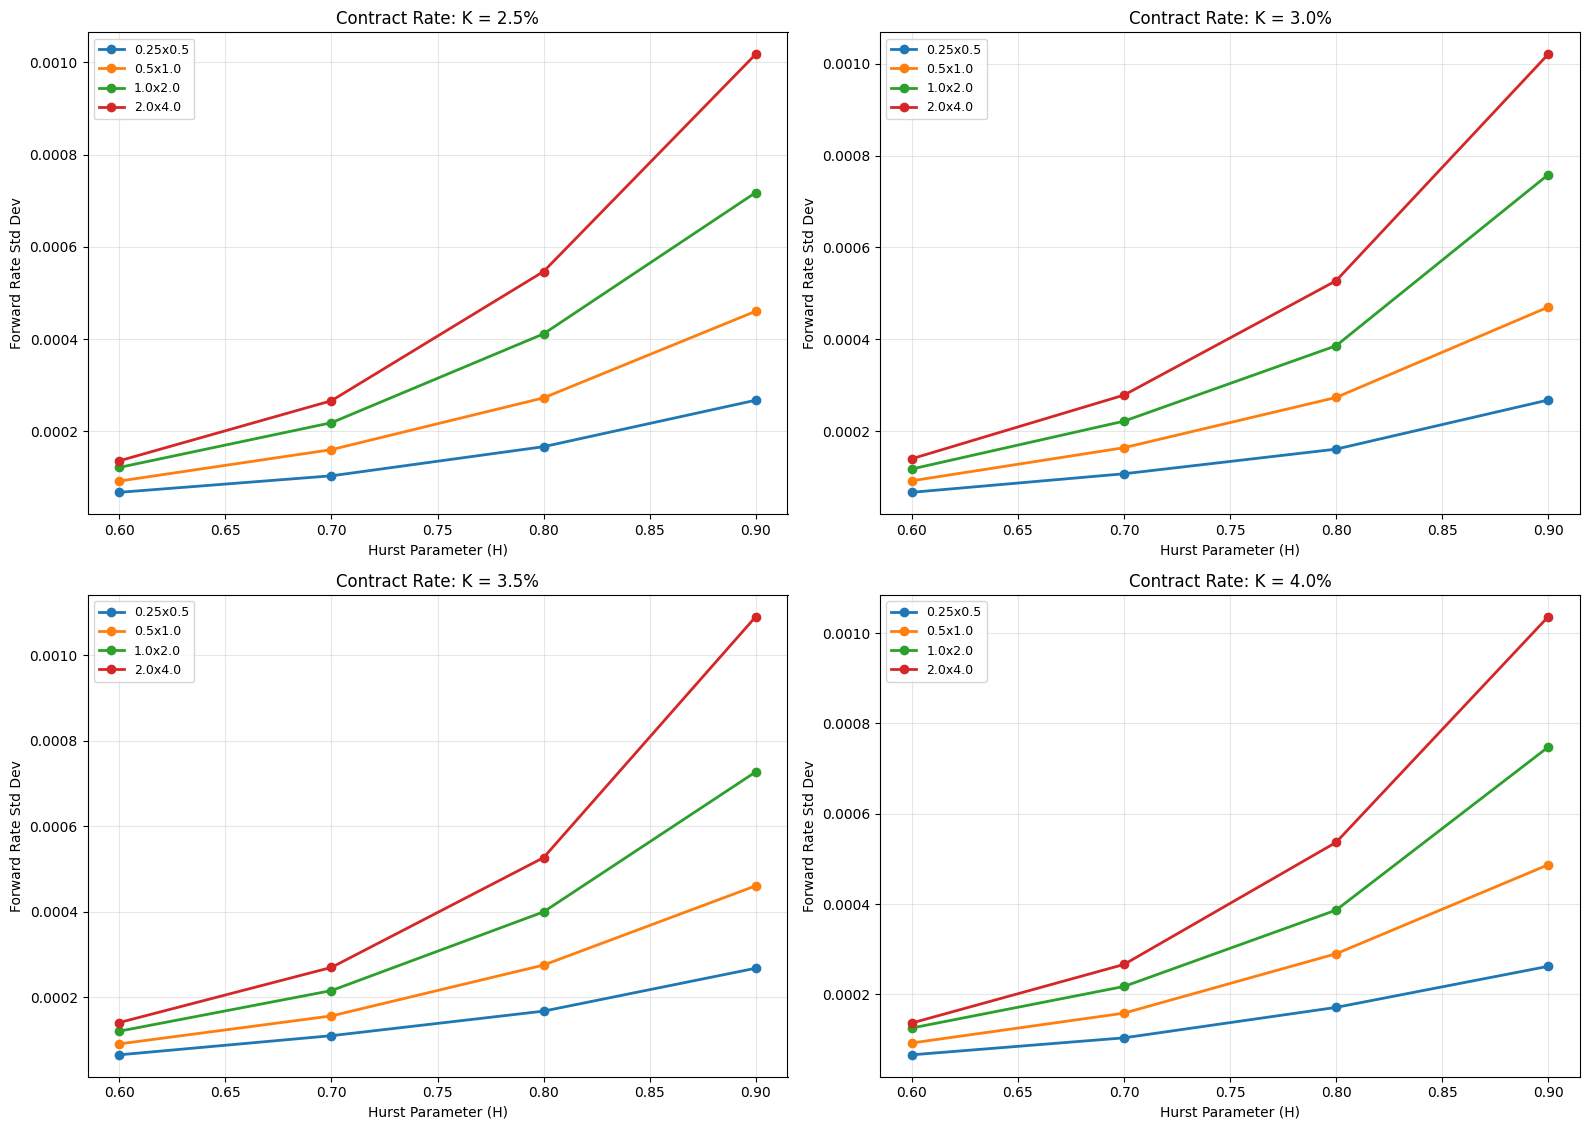

In [6]:
def Std_rate(results, hurst_values, fra_maturities, contract_rates):
    
    metric_sets = [
        ("std_forward_rate", "Forward Rate Std Dev")
    ]

    for metric, label in metric_sets:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        # fig.suptitle(f'{label} vs Hurst Parameter (by Contract Rate)', fontsize=16)

        for idx, K in enumerate(contract_rates):
            row, col = divmod(idx, 2)
            ax = axes[row][col]

            for T_fixing, T_settlement in fra_maturities:
                maturity_key = f"{T_fixing}x{T_settlement}"
                values = [results[maturity_key][K][H][metric] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'{T_fixing}x{T_settlement}', linewidth=2)

            ax.set_title(f'Contract Rate: K = {K:.1%}')
            ax.set_xlabel('Hurst Parameter (H)')
            ax.set_ylabel(label)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    Std_rate(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()

#### Impact of Hurst Parameter on FRA Pricing

1. Mean and Volatility (Standard Deviation)

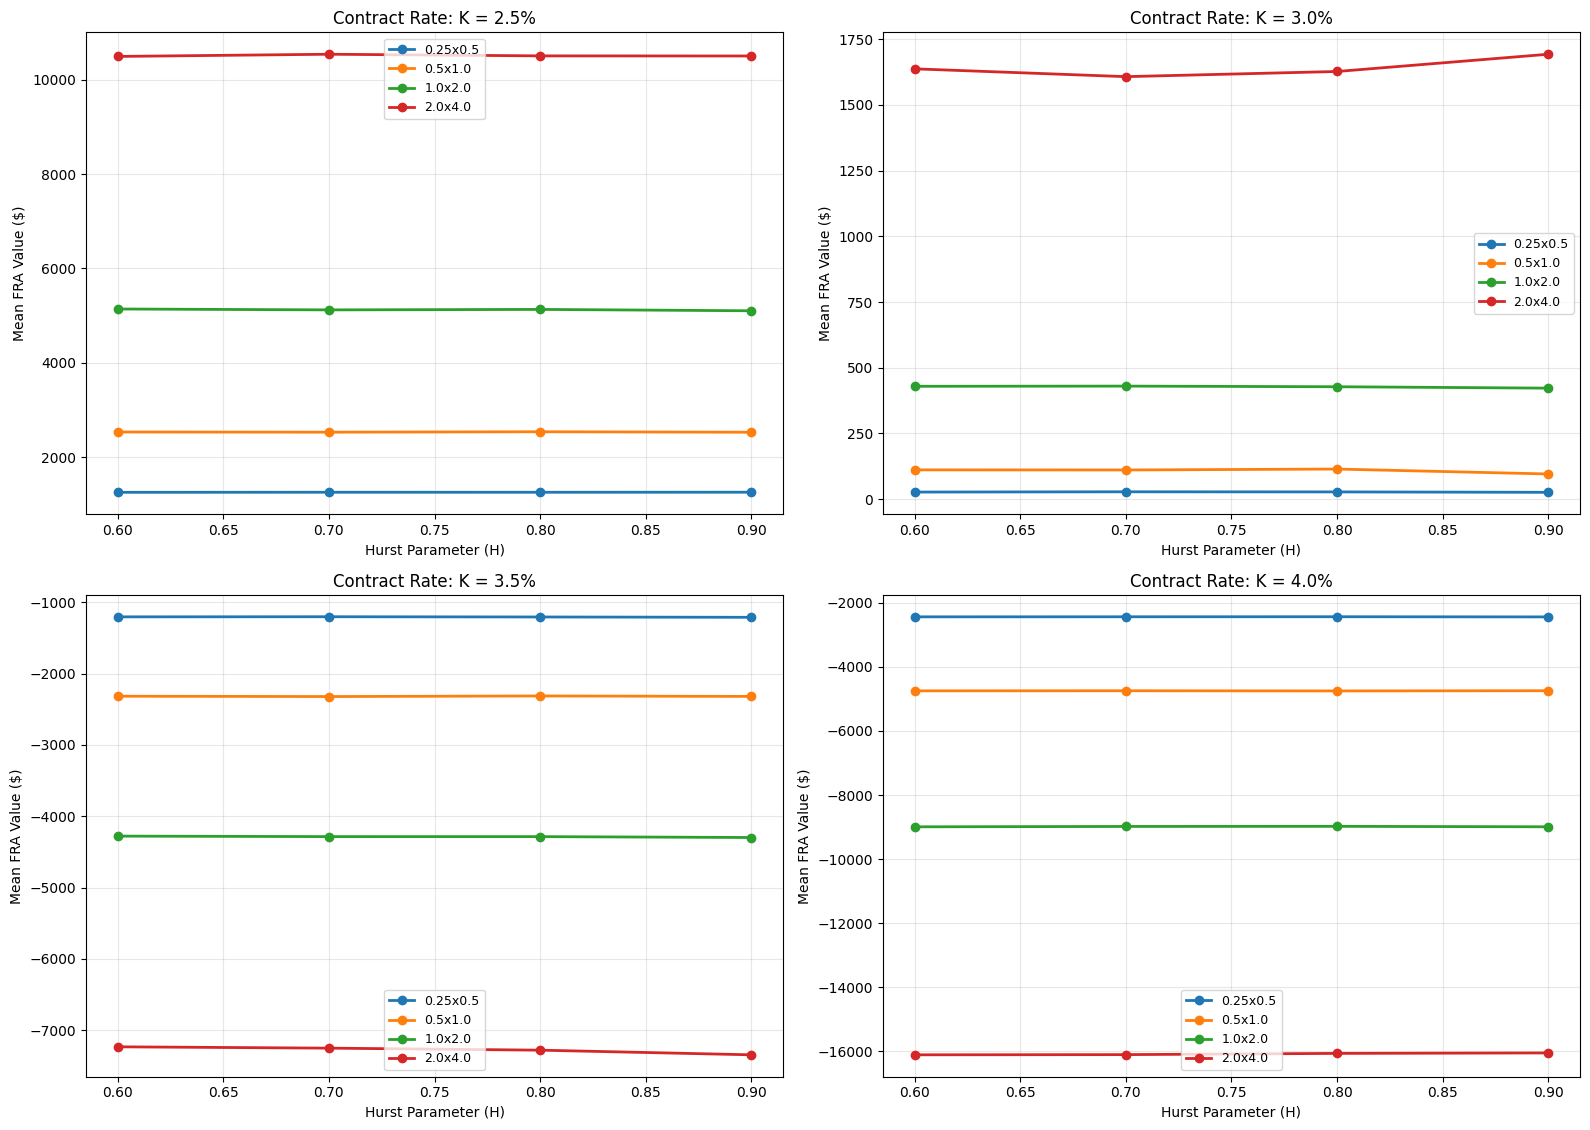

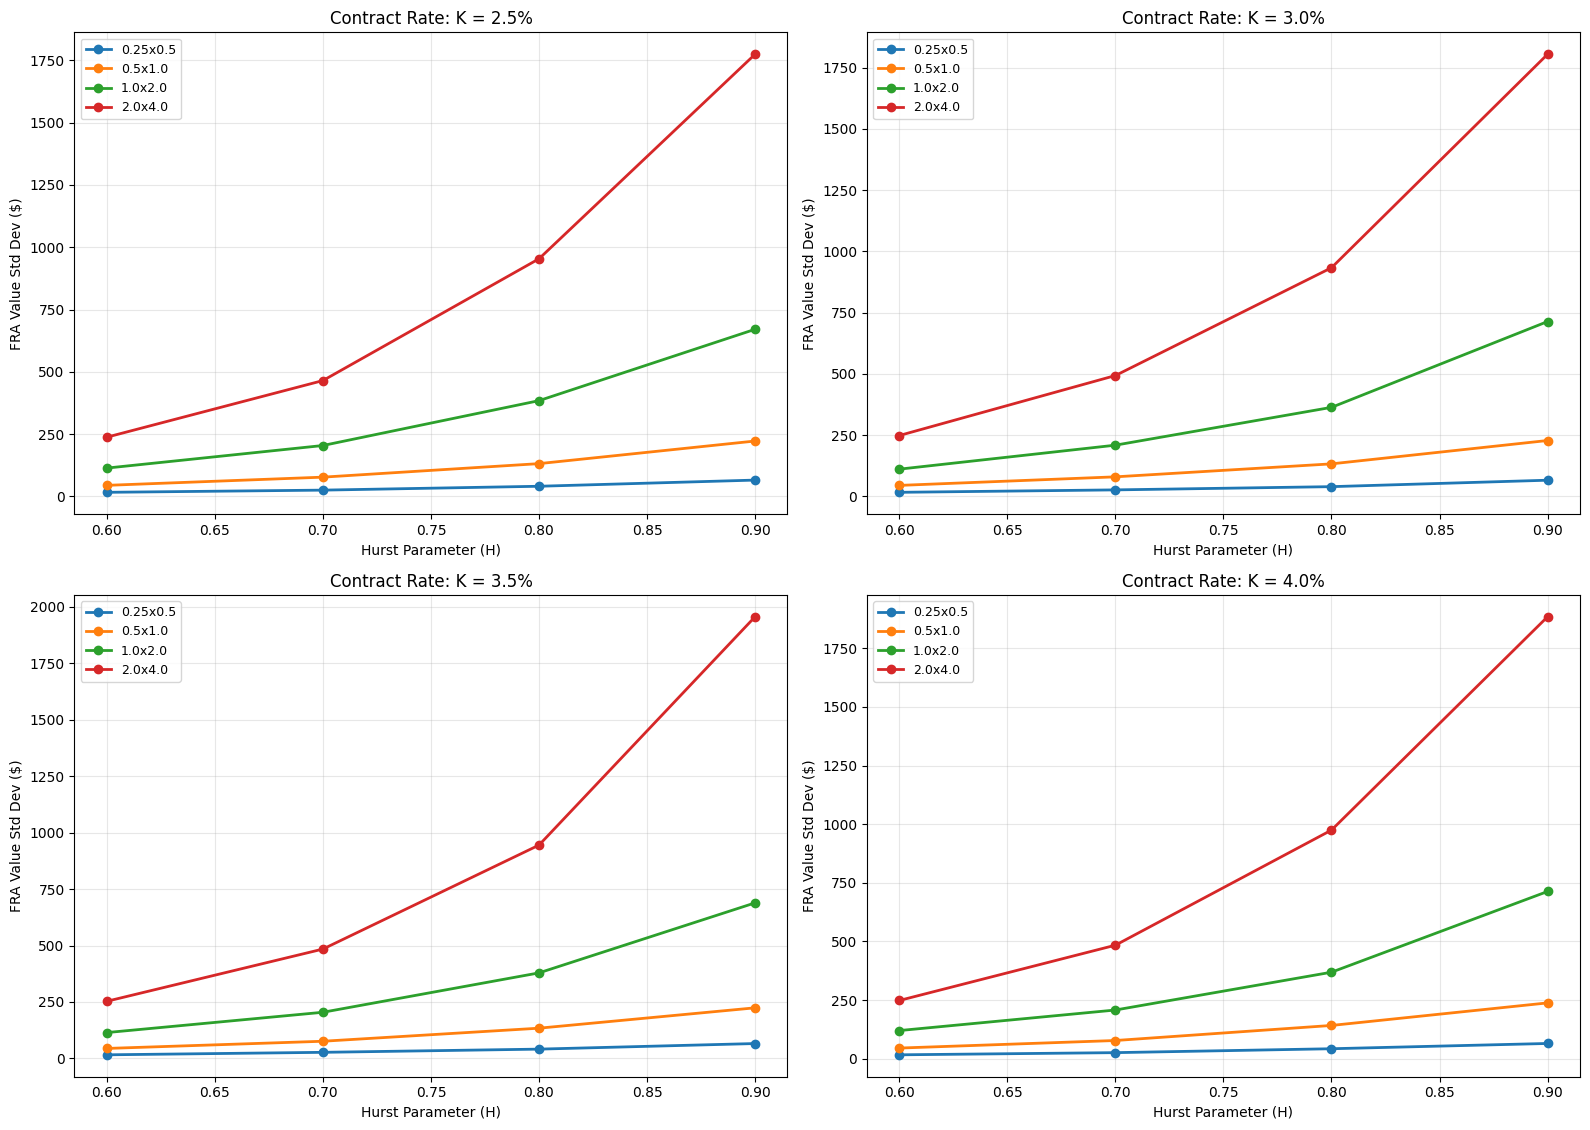

In [7]:
def Mean_Std_FRA(results, hurst_values, fra_maturities, contract_rates):
    metric_sets = [
        ("mean_fra_value", "Mean FRA Value ($)"),
        ("std_fra_value", "FRA Value Std Dev ($)")
    ]

    for metric, label in metric_sets:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        # fig.suptitle(f'{label} vs Hurst Parameter (by Contract Rate)', fontsize=16)

        for idx, K in enumerate(contract_rates):
            row, col = divmod(idx, 2)
            ax = axes[row][col]

            for T_fixing, T_settlement in fra_maturities:
                maturity_key = f"{T_fixing}x{T_settlement}"
                values = [results[maturity_key][K][H][metric] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'{T_fixing}x{T_settlement}', linewidth=2)

            ax.set_title(f'Contract Rate: K = {K:.1%}')
            ax.set_xlabel('Hurst Parameter (H)')
            ax.set_ylabel(label)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    Mean_Std_FRA(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()

2. Distribution

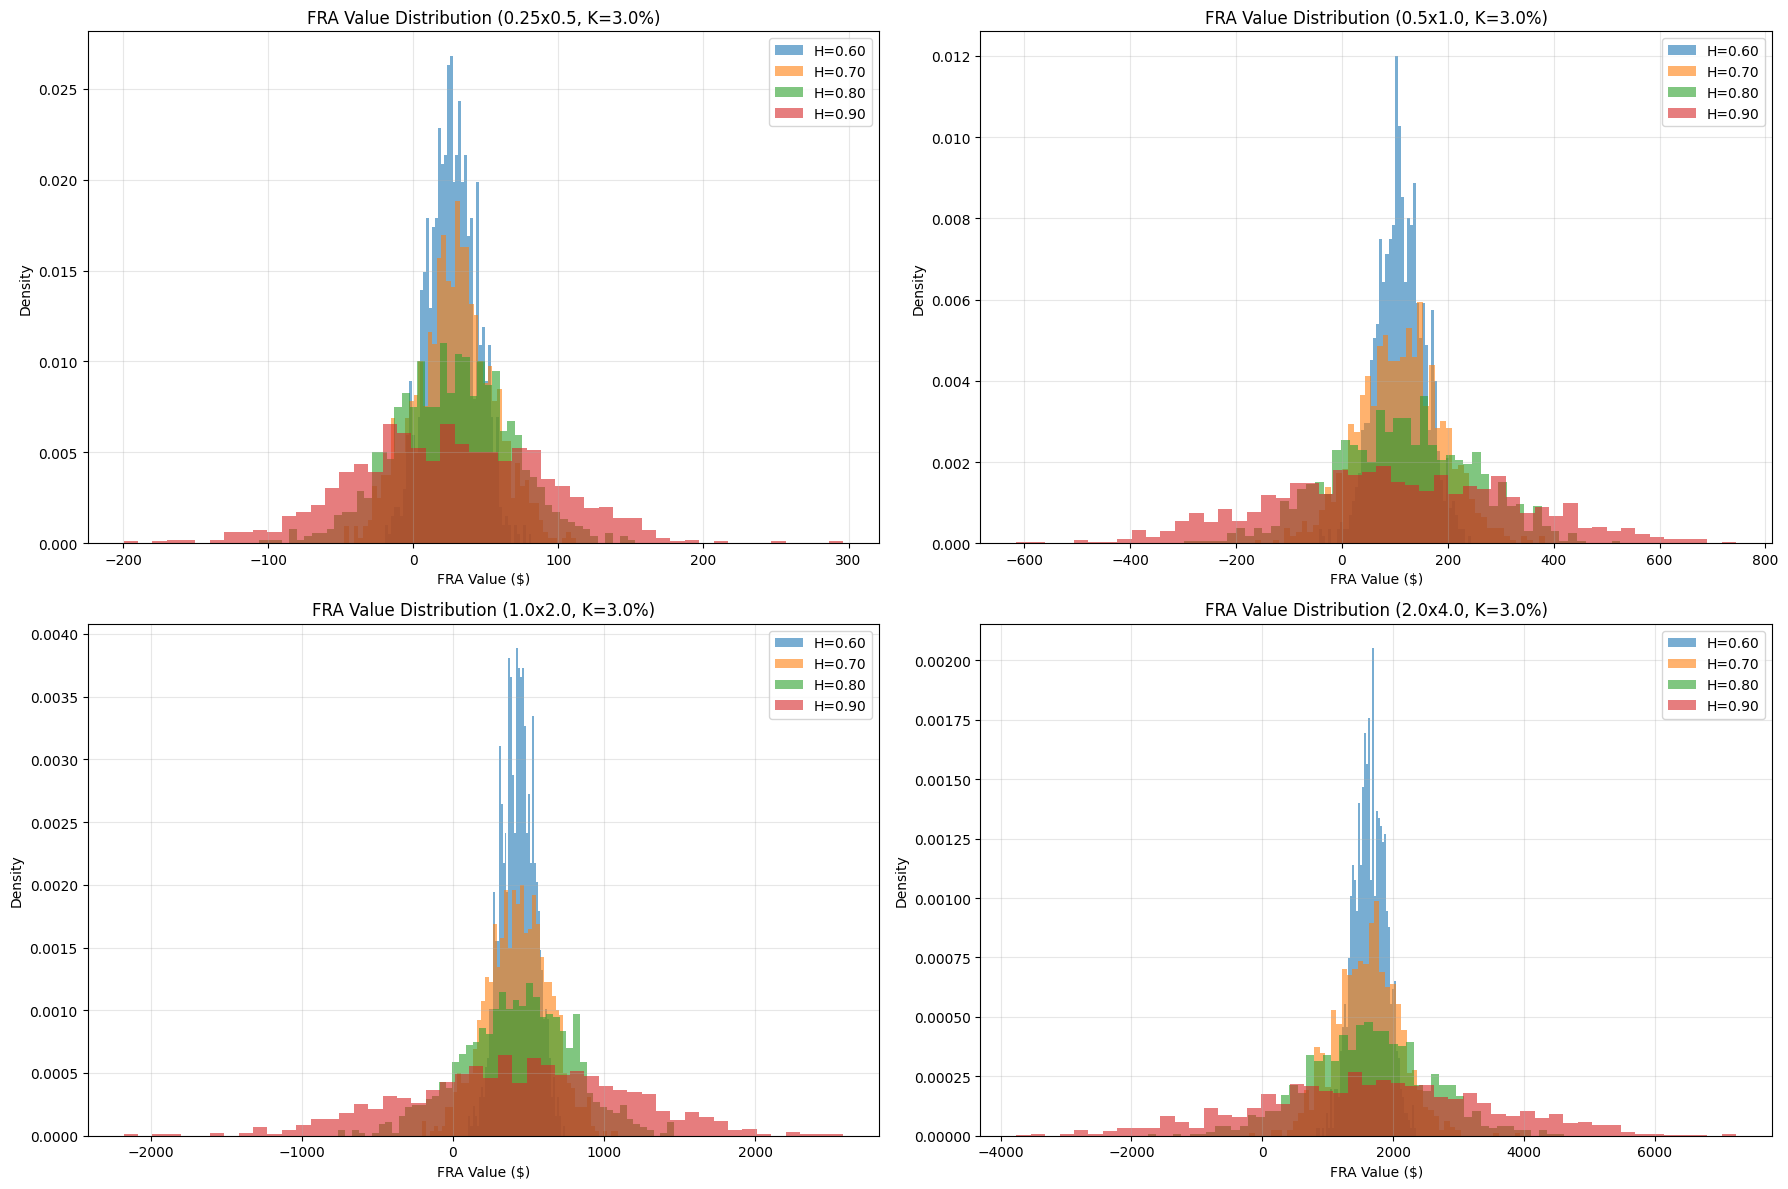

In [9]:
def FRA_distribution(results, hurst_values, fra_maturities, contract_rates):
    # FRA Value Distribution for different Hurst parameters
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    for i, (T_fixing, T_settlement) in enumerate(fra_maturities):
        if i >= 4:
            break
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        maturity_key = f"{T_fixing}x{T_settlement}"
        K_sample = contract_rates[1]  # Use middle contract rate
        
        for H in hurst_values:
            fra_values = results[maturity_key][K_sample][H]['fra_values']
            ax.hist(fra_values, bins=50, alpha=0.6, label=f'H={H:.2f}', density=True)
        
        ax.set_title(f'FRA Value Distribution ({T_fixing}x{T_settlement}, K={K_sample:.1%})')
        ax.set_xlabel('FRA Value ($)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    FRA_distribution(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()   

#### Value at Risk

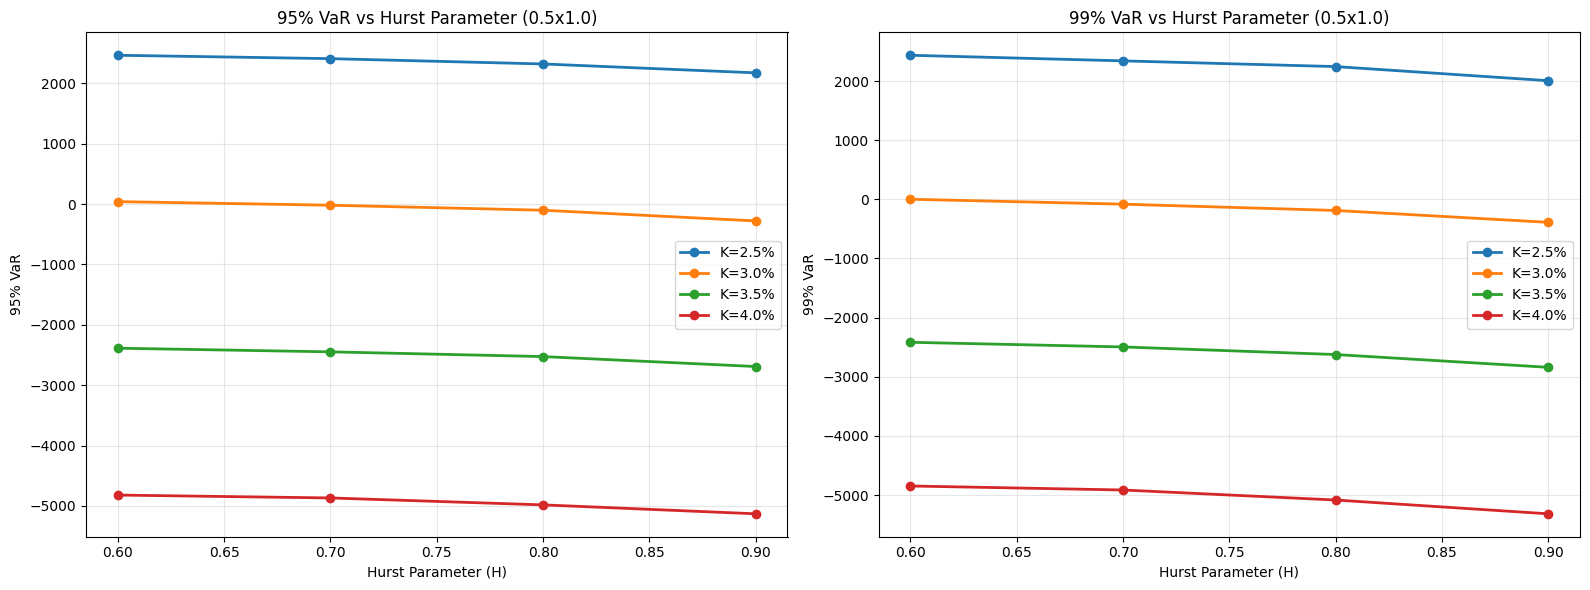

In [3]:
def VaR_fra(results, hurst_values, fra_maturities, contract_rates):
    
    maturity_sample = f"{fra_maturities[1][0]}x{fra_maturities[1][1]}"  # Use 6x12 FRA
    
    # VaR Analysis for different contract rates
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    measures = ['var_95_fra', 'var_99_fra']
    measure_labels = ['95% VaR', '99% VaR']
    
    for i, (measure, label) in enumerate(zip(measures, measure_labels)):
        ax = axes[i]
        
        for K in contract_rates:
            values = [results[maturity_sample][K][H][measure] for H in hurst_values]
            ax.plot(hurst_values, values, 'o-', label=f'K={K:.1%}', linewidth=2, markersize=6)
        
        ax.set_xlabel('Hurst Parameter (H)')
        ax.set_ylabel(label)
        ax.set_title(f'{label} vs Hurst Parameter ({maturity_sample})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    VaR_fra(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()   

In [4]:
def generate_fra_summary_table(results, hurst_values, fra_maturities, contract_rates):
    """
    Generate summary statistics table for FRA pricing results - All contract rates
    """
    print("\n" + "="*120)
    print("SUMMARY TABLE: FORWARD RATE AGREEMENT (FRA) PRICING STATISTICS - ALL CONTRACT RATES")
    print("="*120)
    
    for T_fixing, T_settlement in fra_maturities:
        maturity_key = f"{T_fixing}x{T_settlement}"
        print(f"\nFRA Contract: {T_fixing}x{T_settlement}")
        print("-" * 110)
        
        for K in contract_rates:
            print(f"\nContract Rate K = {K:.1%}")
            print(f"{'H':<6} {'Mean FRA':<12} {'Std FRA':<12} {'Mean Fwd':<12} {'Std Fwd':<12} {'Skew':<8} {'Kurt':<8} {'VaR95':<12}")
            print("-" * 90)
            
            for H in hurst_values:
                stats_h = results[maturity_key][K][H]
                print(f"{H:<6.2f} "
                      f"{stats_h['mean_fra_value']:<12.0f} "
                      f"{stats_h['std_fra_value']:<12.0f} "
                      f"{stats_h['mean_forward_rate']:<12.4f} "
                      f"{stats_h['std_forward_rate']:<12.4f} "
                      f"{stats_h['skewness_fra']:<8.3f} "
                      f"{stats_h['kurtosis_fra']:<8.3f} "
                      f"{stats_h['var_95_fra']:<12.0f}")
                
def main():
    np.random.seed(42)
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    fra_maturities = [
        (0.25, 0.5),   # 3x6 FRA
        (0.5, 1.0),    # 6x12 FRA
        (1.0, 2.0),    # 12x24 FRA
        (2.0, 4.0),    # 24x48 FRA
    ] 
    contract_rates = [0.025, 0.03, 0.035, 0.04] 
    
    # Generate visualizations
    results = comprehensive_fra_analysis(hurst_values, fra_maturities, contract_rates)
    generate_fra_summary_table(results, hurst_values, fra_maturities, contract_rates)
   
    return results

if __name__ == "__main__":
    results = main()   


SUMMARY TABLE: FORWARD RATE AGREEMENT (FRA) PRICING STATISTICS - ALL CONTRACT RATES

FRA Contract: 0.25x0.5
--------------------------------------------------------------------------------------------------------------

Contract Rate K = 2.5%
H      Mean FRA     Std FRA      Mean Fwd     Std Fwd      Skew     Kurt     VaR95       
------------------------------------------------------------------------------------------
0.60   1259         17           0.0301       0.0001       -0.139   0.228    1230        
0.70   1260         25           0.0301       0.0001       0.199    0.125    1220        
0.80   1260         41           0.0301       0.0002       0.026    -0.008   1192        
0.90   1261         66           0.0301       0.0003       -0.053   -0.094   1156        

Contract Rate K = 3.0%
H      Mean FRA     Std FRA      Mean Fwd     Std Fwd      Skew     Kurt     VaR95       
------------------------------------------------------------------------------------------
0.60   27 

## 4.4 Cap and Floor Pricing

#### 4.4.1 Theoretical Pricing Framework

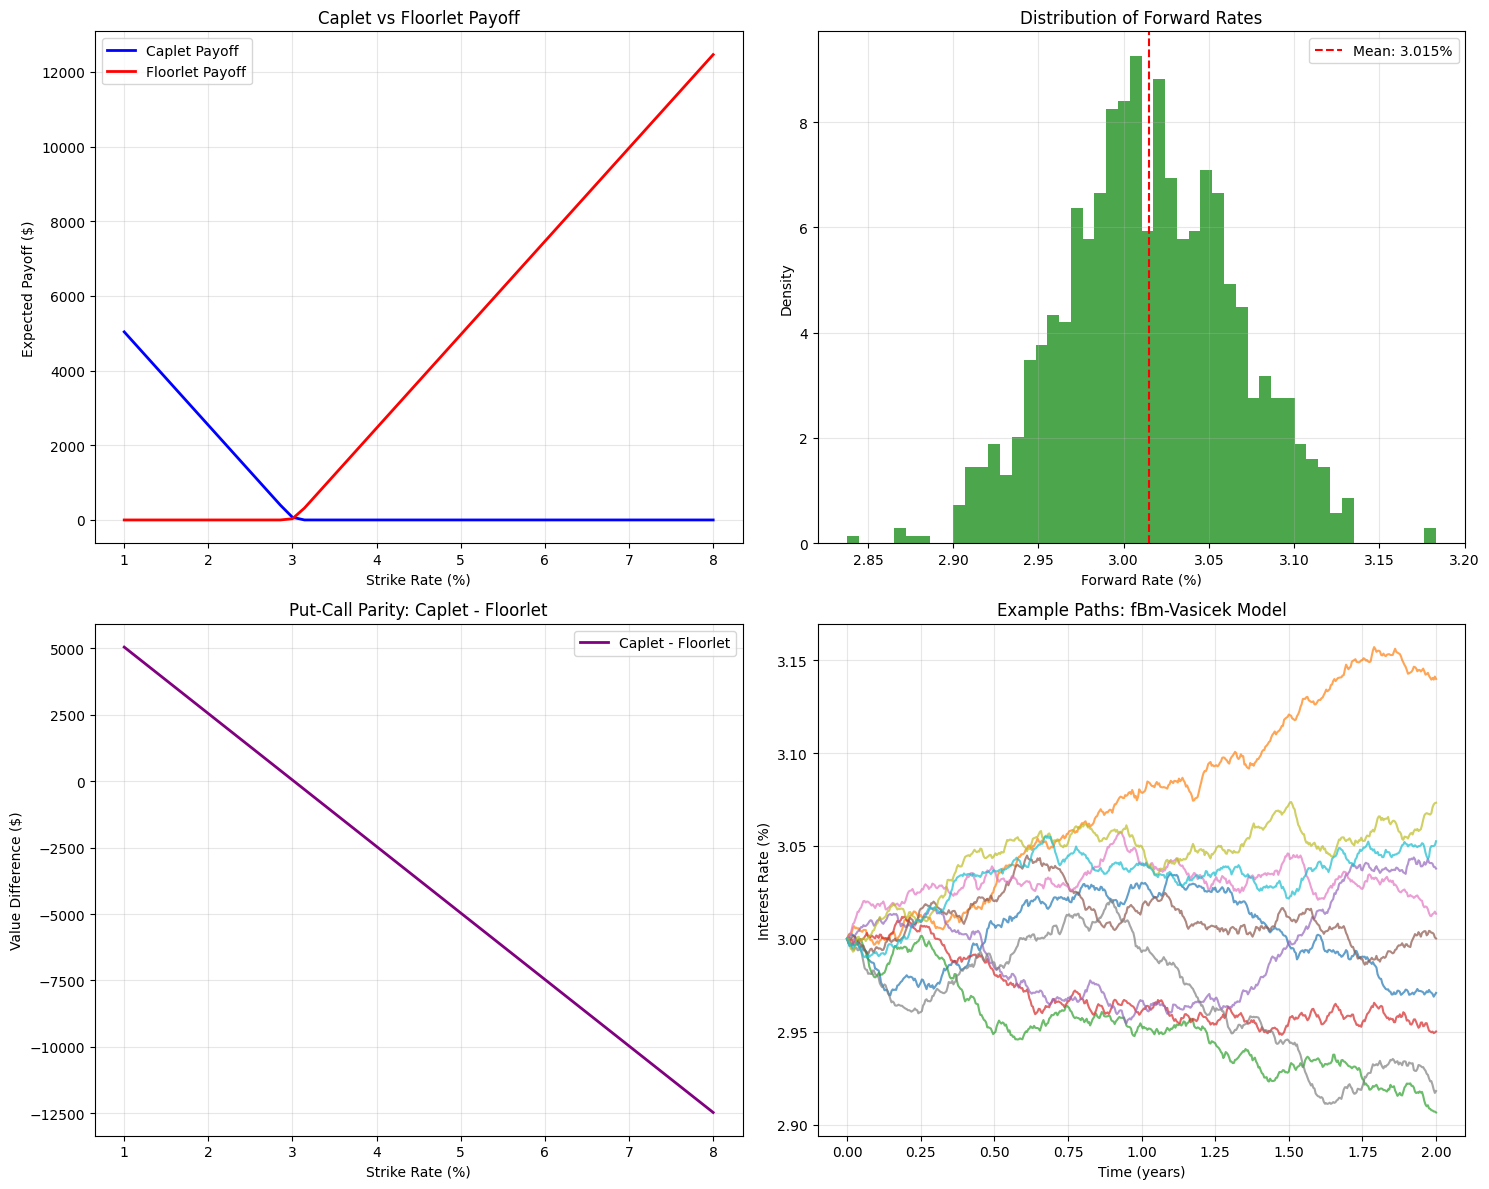

4.4.1 Theoretical Pricing Framework - Summary Statistics
Model Parameters:
  Mean-reversion speed (α): 0.5
  Long-term mean (μ): 3.000%
  Volatility (σ): 0.2
  Initial rate (r₀): 3.000%

Forward Rate Statistics:
  Mean: 3.0093%
  Std Dev: 0.0500%
  Min: 2.8384%
  Max: 3.1689%

ATM Analysis (Strike ≈ 3.000%):
  Caplet Expected Payoff: $62.47
  Floorlet Expected Payoff: $39.33
  Put-Call Parity Gap: $23.15


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import warnings
warnings.filterwarnings('ignore')

class TheoreticalCapFloorFramework:
    """
    Theoretical Pricing Framework for Cap and Floor:
    Basic formulas, payoff structures, and model simulation
    """
    
    def __init__(self, alpha, mu, sigma, r0):
        self.alpha = alpha  # Mean-reversion speed
        self.mu = mu        # Long-term mean
        self.sigma = sigma  # Volatility
        self.r0 = r0        # Initial interest rate
    
    def generate_fbm_increments(self, M, N, T, H):
        """Generate fractional Brownian motion increments via Davies–Harte method"""
        def autocovariance(k, H):
            return 0.5 * (abs(k - 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k + 1)**(2 * H))
        
        dt = T / N
        cov = np.zeros(2 * N)
        for k in range(2 * N):
            j = k if k <= N else 2 * N - k
            cov[k] = autocovariance(j, H)
        
        eigenvals = np.real(fft(cov))
        eigenvals = np.maximum(eigenvals, 1e-10)
        
        Z = np.random.normal(size=(M, 2 * N)) + 1j * np.random.normal(size=(M, 2 * N))
        W = np.sqrt(eigenvals / (2 * N)) * Z
        fGn = np.fft.ifft(W).real[:, :N]
        fBm_increments = fGn * np.sqrt(dt)
        
        return fBm_increments
    
    def generate_fbm_paths(self, M, N, T, H):
        """Generate fBm paths by cumulative sum of increments"""
        fbm_increments = self.generate_fbm_increments(M, N, T, H)
        fbm_paths = np.zeros((M, N + 1))
        fbm_paths[:, 1:] = np.cumsum(fbm_increments, axis=1)
        return fbm_paths
    
    def simulate_rate_paths(self, M, T, H, steps_per_year=252):
        """Simulate interest rate paths via Young integration (H > 0.5 required)"""
        if H <= 0.5:
            raise ValueError("Young integration requires H > 0.5")
        
        N = int(T * steps_per_year)
        dt = T / N
        time_grid = np.linspace(0, T, N + 1)
        
        fbm_paths = self.generate_fbm_paths(M, N, T, H)
        r_paths = np.zeros((M, N + 1))
        r_paths[:, 0] = self.r0
        
        for i in range(N):
            exp_alpha_dt = np.exp(-self.alpha * dt)
            mean_reversion = self.mu * (1 - exp_alpha_dt)
            correction_factor = (1 - exp_alpha_dt) / (self.alpha * dt) if self.alpha * dt > 1e-10 else 1.0
            stochastic_term = self.sigma * (fbm_paths[:, i + 1] - fbm_paths[:, i]) * correction_factor
            r_paths[:, i + 1] = r_paths[:, i] * exp_alpha_dt + mean_reversion + stochastic_term
        
        return r_paths, dt, fbm_paths, time_grid
    
    def theoretical_caplet_payoff(self, L_i, K, N, tau_i):
        """Caplet payoff: N * τᵢ * max(Lᵢ - K, 0)"""
        return N * tau_i * np.maximum(L_i - K, 0)
    
    def theoretical_floorlet_payoff(self, L_i, K, N, tau_i):
        """Floorlet payoff: N * τᵢ * max(K - Lᵢ, 0)"""
        return N * tau_i * np.maximum(K - L_i, 0)
    
    def compute_discount_factor(self, r_paths, dt, t, T):
        """Compute discount factor P(t,T) ≈ exp(-∑rₜₖΔtₖ)"""
        t_steps = int(t / dt)
        T_steps = int(T / dt)
        T_steps = min(T_steps, r_paths.shape[1] - 1)
        
        if t_steps >= T_steps:
            return np.ones(r_paths.shape[0])
        
        rate_integral = np.sum(r_paths[:, t_steps:T_steps] * dt, axis=1)
        return np.exp(-rate_integral)
    
    def compute_forward_rate(self, r_paths, dt, T_fixing, T_settlement):
        """
        Compute forward rate:
        Lᵢ = (1/τᵢ) * (P(Tᵢ,Tᵢ)/P(Tᵢ,Tᵢ₊₁) - 1)
        """
        P_Ti_Ti = np.ones(r_paths.shape[0])
        P_Ti_Ti_plus_1 = self.compute_discount_factor(r_paths, dt, T_fixing, T_settlement)
        P_Ti_Ti_plus_1 = np.maximum(P_Ti_Ti_plus_1, 1e-10)
        
        tau_i = T_settlement - T_fixing
        forward_rates = (1 / tau_i) * (P_Ti_Ti / P_Ti_Ti_plus_1 - 1)
        
        return forward_rates
    
    def demonstrate_payoff_structures(self, strike_range=(0.01, 0.08), num_strikes=50):
        """Demonstrate caplet/floorlet payoff structures across strike levels"""
        M = 1000
        T = 2.0
        H = 0.7
        
        r_paths, dt, _, _ = self.simulate_rate_paths(M, T, H)
        T_fixing = 1.0
        T_settlement = 1.25
        forward_rates = self.compute_forward_rate(r_paths, dt, T_fixing, T_settlement)
        
        strikes = np.linspace(strike_range[0], strike_range[1], num_strikes)
        N_notional = 1000000
        tau_i = T_settlement - T_fixing
        
        caplet_payoffs = []
        floorlet_payoffs = []
        
        for K in strikes:
            cap_payoff = np.mean(self.theoretical_caplet_payoff(forward_rates, K, N_notional, tau_i))
            floor_payoff = np.mean(self.theoretical_floorlet_payoff(forward_rates, K, N_notional, tau_i))
            caplet_payoffs.append(cap_payoff)
            floorlet_payoffs.append(floor_payoff)
        
        return strikes, caplet_payoffs, floorlet_payoffs, forward_rates
    
    def plot_theoretical_framework(self):
        """Plot figures for theoretical cap/floor pricing framework"""
        strikes, caplet_payoffs, floorlet_payoffs, forward_rates = self.demonstrate_payoff_structures()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        # fig.suptitle('Theoretical Pricing Framework of Cap and Floor', fontsize=16, fontweight='bold')
        
        # 1. Cap vs Floor Payoff Structure
        axes[0, 0].plot(strikes * 100, caplet_payoffs, 'b-', linewidth=2, label='Caplet Payoff')
        axes[0, 0].plot(strikes * 100, floorlet_payoffs, 'r-', linewidth=2, label='Floorlet Payoff')
        axes[0, 0].set_xlabel('Strike Rate (%)')
        axes[0, 0].set_ylabel('Expected Payoff ($)')
        axes[0, 0].set_title('Caplet vs Floorlet Payoff')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Distribution of Forward Rates
        axes[0, 1].hist(forward_rates * 100, bins=50, density=True, alpha=0.7, color='green')
        axes[0, 1].axvline(np.mean(forward_rates) * 100, color='red', linestyle='--', label=f'Mean: {np.mean(forward_rates):.3%}')
        axes[0, 1].set_xlabel('Forward Rate (%)')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].set_title('Distribution of Forward Rates')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Put-Call Parity
        parity_values = np.array(caplet_payoffs) - np.array(floorlet_payoffs)
        axes[1, 0].plot(strikes * 100, parity_values, 'purple', linewidth=2, label='Caplet - Floorlet')
        axes[1, 0].set_xlabel('Strike Rate (%)')
        axes[1, 0].set_ylabel('Value Difference ($)')
        axes[1, 0].set_title('Put-Call Parity: Caplet - Floorlet')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Example Rate Paths
        M_demo = 10
        r_paths_demo, dt, _, time_grid = self.simulate_rate_paths(M_demo, 2.0, 0.7)
        for i in range(M_demo):
            axes[1, 1].plot(time_grid, r_paths_demo[i] * 100, alpha=0.7)
        axes[1, 1].set_xlabel('Time (years)')
        axes[1, 1].set_ylabel('Interest Rate (%)')
        axes[1, 1].set_title('Example Paths: fBm-Vasicek Model')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def summary_statistics(self):
        """Print key statistics from theoretical framework demonstration"""
        strikes, caplet_payoffs, floorlet_payoffs, forward_rates = self.demonstrate_payoff_structures()
        
        print("=" * 60)
        print("4.4.1 Theoretical Pricing Framework - Summary Statistics")
        print("=" * 60)
        print("Model Parameters:")
        print(f"  Mean-reversion speed (α): {self.alpha}")
        print(f"  Long-term mean (μ): {self.mu:.3%}")
        print(f"  Volatility (σ): {self.sigma}")
        print(f"  Initial rate (r₀): {self.r0:.3%}\n")
        
        print("Forward Rate Statistics:")
        print(f"  Mean: {np.mean(forward_rates):.4%}")
        print(f"  Std Dev: {np.std(forward_rates):.4%}")
        print(f"  Min: {np.min(forward_rates):.4%}")
        print(f"  Max: {np.max(forward_rates):.4%}\n")
        
        atm_idx = np.argmin(np.abs(strikes - np.mean(forward_rates)))
        print(f"ATM Analysis (Strike ≈ {strikes[atm_idx]:.3%}):")
        print(f"  Caplet Expected Payoff: ${caplet_payoffs[atm_idx]:,.2f}")
        print(f"  Floorlet Expected Payoff: ${floorlet_payoffs[atm_idx]:,.2f}")
        print(f"  Put-Call Parity Gap: ${caplet_payoffs[atm_idx] - floorlet_payoffs[atm_idx]:,.2f}")
        
        return {
            'forward_rate_stats': {
                'mean': np.mean(forward_rates),
                'std': np.std(forward_rates),
                'min': np.min(forward_rates),
                'max': np.max(forward_rates)
            },
            'atm_analysis': {
                'strike': strikes[atm_idx],
                'caplet_payoff': caplet_payoffs[atm_idx],
                'floorlet_payoff': floorlet_payoffs[atm_idx],
                'parity_diff': caplet_payoffs[atm_idx] - floorlet_payoffs[atm_idx]
            }
        }

# Example usage
if __name__ == "__main__":
    framework = TheoreticalCapFloorFramework(alpha=0.5, mu=0.03, sigma=0.2, r0=0.03)
    fig = framework.plot_theoretical_framework()
    plt.show()
    
    stats = framework.summary_statistics()


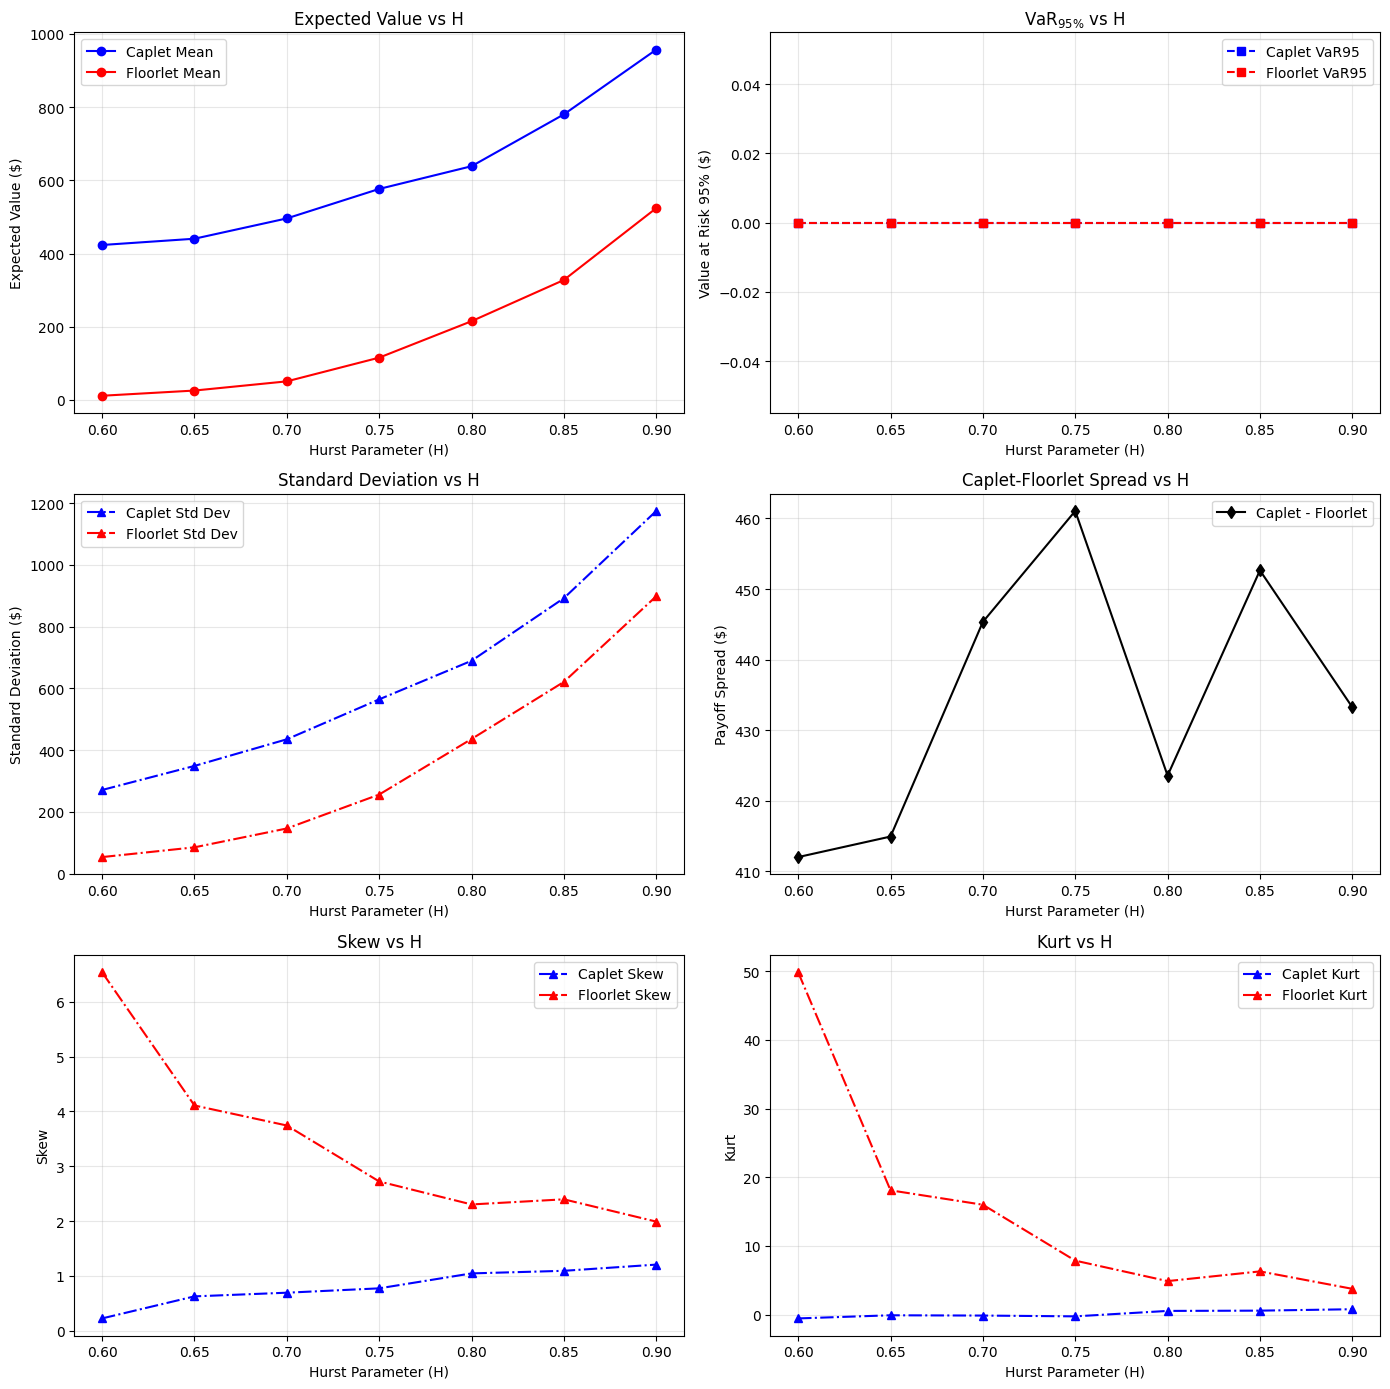

In [28]:
from scipy import stats

class CapFloorHurstExperiment:
    """
    4.4.2 Cap/Floor Experiment: Effects of Hurst Memory on Pricing
    """
    def __init__(self, model, N_notional, K_list, maturity_pair, hurst_values, M=1000):
        self.model = model
        self.N = N_notional
        self.K_list = K_list
        self.T_fixing, self.T_settlement = maturity_pair
        self.tau_i = self.T_settlement - self.T_fixing
        self.hurst_values = hurst_values
        self.M = M
        self.results = {}

    def run(self):
        for K in self.K_list:
            self.results[K] = {}
            for H in self.hurst_values:
                max_T = max(self.T_settlement, 2.0)
                r_paths, dt, fbm_paths, time_grid = self.model.simulate_rate_paths(self.M, max_T, H)
                
                # Compute forward rate
                forward_rates = self.model.compute_forward_rate(r_paths, dt, self.T_fixing, self.T_settlement)
                P_t_T = self.model.compute_discount_factor(r_paths, dt, 0.0, self.T_settlement)

                caplet_payoff = self.model.theoretical_caplet_payoff(forward_rates, K, self.N, self.tau_i)
                floorlet_payoff = self.model.theoretical_floorlet_payoff(forward_rates, K, self.N, self.tau_i)

                caplet_values = caplet_payoff * P_t_T
                floorlet_values = floorlet_payoff * P_t_T

                self.results[K][H] = {
                    'caplet': {
                        'mean': np.mean(caplet_values),
                        'std': np.std(caplet_values),
                        'VaR95': np.percentile(caplet_values, 5),
                        'skew': stats.skew(caplet_values),
                        'kurt': stats.kurtosis(caplet_values),
                        'values': caplet_values
                    },
                    'floorlet': {
                        'mean': np.mean(floorlet_values),
                        'std': np.std(floorlet_values),
                        'VaR95': np.percentile(floorlet_values, 5),
                        'skew': stats.skew(floorlet_values),
                        'kurt': stats.kurtosis(floorlet_values),
                        'values': floorlet_values
                    },
                    'forward_rates': forward_rates,
                    'sample_paths': r_paths[:10]
                }
        return self.results

def plot_capfloor_hurst_analysis(results, K_target):
    """
    Visualize caplet and floorlet pricing metrics across different Hurst parameters
    for a fixed strike rate K.
    """
    H_values = sorted(results[K_target].keys())
    
    caplet_means = [results[K_target][H]['caplet']['mean'] for H in H_values]
    floorlet_means = [results[K_target][H]['floorlet']['mean'] for H in H_values]

    caplet_vars = [results[K_target][H]['caplet']['VaR95'] for H in H_values]
    floorlet_vars = [results[K_target][H]['floorlet']['VaR95'] for H in H_values]

    caplet_stds = [results[K_target][H]['caplet']['std'] for H in H_values]
    floorlet_stds = [results[K_target][H]['floorlet']['std'] for H in H_values]

    caplet_skew = [results[K_target][H]['caplet']['skew'] for H in H_values]
    floorlet_skew = [results[K_target][H]['floorlet']['skew'] for H in H_values]

    caplet_kurt = [results[K_target][H]['caplet']['kurt'] for H in H_values]
    floorlet_kurt = [results[K_target][H]['floorlet']['kurt'] for H in H_values]

    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    # fig.suptitle(f"Impact of Hurst Parameter on Caplet/Floorlet Values (K = {K_target*100:.2f}%)", fontsize=15)

    # Mean
    axes[0, 0].plot(H_values, caplet_means, 'b-o', label='Caplet Mean')
    axes[0, 0].plot(H_values, floorlet_means, 'r-o', label='Floorlet Mean')
    axes[0, 0].set_title('Expected Value vs H')
    axes[0, 0].set_xlabel('Hurst Parameter (H)')
    axes[0, 0].set_ylabel('Expected Value ($)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # VaR 95%
    axes[0, 1].plot(H_values, caplet_vars, 'b--s', label='Caplet VaR95')
    axes[0, 1].plot(H_values, floorlet_vars, 'r--s', label='Floorlet VaR95')
    axes[0, 1].set_title('VaR$_{95\%}$ vs H')
    axes[0, 1].set_xlabel('Hurst Parameter (H)')
    axes[0, 1].set_ylabel('Value at Risk 95% ($)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Std Dev
    axes[1, 0].plot(H_values, caplet_stds, 'b-.^', label='Caplet Std Dev')
    axes[1, 0].plot(H_values, floorlet_stds, 'r-.^', label='Floorlet Std Dev')
    axes[1, 0].set_title('Standard Deviation vs H')
    axes[1, 0].set_xlabel('Hurst Parameter (H)')
    axes[1, 0].set_ylabel('Standard Deviation ($)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # Cap vs Floor Spread
    spread = [cap - floor for cap, floor in zip(caplet_means, floorlet_means)]
    axes[1, 1].plot(H_values, spread, 'k-d', label='Caplet - Floorlet')
    axes[1, 1].set_title('Caplet-Floorlet Spread vs H')
    axes[1, 1].set_xlabel('Hurst Parameter (H)')
    axes[1, 1].set_ylabel('Payoff Spread ($)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    # Skew
    axes[2, 0].plot(H_values, caplet_skew, 'b-.^', label='Caplet Skew')
    axes[2, 0].plot(H_values, floorlet_skew, 'r-.^', label='Floorlet Skew')
    axes[2, 0].set_title('Skew vs H')
    axes[2, 0].set_xlabel('Hurst Parameter (H)')
    axes[2, 0].set_ylabel('Skew')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].legend()

    # Skew
    axes[2, 1].plot(H_values, caplet_kurt, 'b-.^', label='Caplet Kurt')
    axes[2, 1].plot(H_values, floorlet_kurt, 'r-.^', label='Floorlet Kurt')
    axes[2, 1].set_title('Kurt vs H')
    axes[2, 1].set_xlabel('Hurst Parameter (H)')
    axes[2, 1].set_ylabel('Kurt')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].legend()

    plt.tight_layout()
    plt.show()

framework = TheoreticalCapFloorFramework(alpha=0.5, mu=0.03, sigma=0.2, r0=0.03)
experiment = CapFloorHurstExperiment(
    model=framework,
    N_notional=1_000_000,
    K_list=[0.025, 0.03, 0.035],
    maturity_pair=(1.0, 2.0),
    hurst_values=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    M=1000
)
results = experiment.run()

plot_capfloor_hurst_analysis(results, K_target=0.03)